# Project Title | Classification of Crisis-related Tweets

## Introduction

Social media has emerged as an invaluable resource for humanitarian aid organizations to get real-time information about the situation on the ground
during a natural disaster. Microblogging platforms like Twitter allow individuals to easily and quickly relay information on location, time, damage severity, etc. to the public at large. With a clearer understanding of what is happening at a micro-level, humanitarian aid organizations can more efficiently allocate and dispatch assistance, as well as inform victims about where and how to seek help. 

**While social media has the advantage of real-time information transmission during a fast-changing crisis, the sudden flood of posts and messages can easily overwhelm humanitarian organizations hoping to act on critical and relevant information.** Not all posts and messages tied to a disaster-related event are informative and useful to these organizations.

**Machine Learning models can help play a role in the task of sifting through the deluge of disaster-related posts and identify which posts are the most informative for humanitarian aid purposes.**

This project will compare **Many classification machine learning models** (**Multinomial Naive-Bayes**, **CatBoostClassifier**, **LogisticRegression**, **RandomForestClassifier**, **XGBoost**, **GradientBoostingClassifier** and **K-Nearest Neighbors**) on this task and propose which model could perform the most effectively during a diaster-related event. For our models, we will train and test them on tweets that have been gathered from 7 natural disasters occurring during 2017: Hurricanes Irma, Harvey, and Maria; Earthquakes in Mexico and Iran & Iraq; Wildfires in California; and Floods in Sri Lanka.   

## Objective

**Business Objective:**

To accurately classify tweets related to natural disasters as informative or not informative, thereby enhancing the ability of humanitarian organizations to quickly identify and utilize valuable information for disaster response and relief efforts.

## Data

### Source

The data for this project comes from the **CrisisMMD (Crisis Multi-Modal Dataset)** https://crisisnlp.qcri.org/crisismmd, a collection gathered and made available by the **Crisis Computing team** at **Qatar Computing Research Institute (QCRI)** of **Hamad Bin Khalifa University (HBKU)**. 

Within this dataset are thousands of **tweets** sampled from over 14 million tweets collected during **seven major disasters** (earthquakes, floods, hurricanes, and wildfires) occurring in **2017** in various parts of the world (United States, Puerto Rico, Mexico, Sri Lanka, Iran and Iraq): **Hurricane Irma, Hurricane Harvey, Hurricane Maria, California wildfires, Mexico earthquake, Iran-Iraq earthquake, **and the** Sri Lanka floods**. 

### Annotation

Tweets have been manually annotated with three types of labels.

1. **Informative vs Not informative** (Text and Image)
    - Informative
    - Not informative

2. **Humanitarian Categories** (Text and Image)
    - Affected individuals
    - Infrastructure and utility damage
    - Injured or dead people
    - Missing or found people
    - Rescue, volunteering or donation effort
    - Vehicle damage
    - Other relevant information
    - Not humanitarian
    
3. **Damage Severity Assessment** (Image)
    - Severe damage
    - Mild damage
    - Little or no damage
    - Don't know or can't judge
    
However, for this project our focus will only be textual analysis and only focus on the labels for **Informative vs. Not informative**. We will discard image-related data as well as the labels for **Humanitarian Categoreis** and **Damage Severity Assessment**. 

The label **Informative vs. Not informative** indicates whether or not the text of the tweet is useful for humanitarian aid purposes.  


## PreProcessing

### Import Necessary Libraries

I will load every libraries that I am going to use throughout this project. I will group the libraries by their use. This will make it easier to read for you.

In [114]:
# basic libraries

import os
import gc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


# libraries for data ingestion
import zipfile
import requests
import traceback
import urllib.request as request


# Libraries for cleaning.
import re
import nltk
import emoji
import string
from autocorrect import Speller
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


nltk.download('all', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)



# Libraries for EDA
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Libraries for Feature Extraction
from sklearn.model_selection import train_test_split



# Libraries for Model Selection
from tabulate import tabulate
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)
from sklearn.pipeline import Pipeline


# Libraries for Model Optimization
from sklearn.model_selection import GridSearchCV, cross_validate



# python dataclass decorator
from dataclasses import dataclass


# custom functions
from src.logger import log
from src.exception import CustomException

### Data Ingestion

In this stage, we will getting our data from github where I stored the files. We will download, extract, Convert each TSV file to CSV, and combine them into one CSV file.

In [2]:
# Step 1: Define the base directory for the dataset
base_dir = 'dataset'
os.makedirs(base_dir, exist_ok=True)
print(f"Base directory created at {base_dir}")

Base directory created at dataset


In [3]:
# Step 2: Define the URL of the source data to be downloaded

# URL of the source data to be downloaded
source_url: str = "https://github.com/xplict33/mlproject/raw/main/data.zip"

# Paths within the base directory
zip_dir = os.path.join(base_dir, "data.zip")
raw_data_dir = os.path.join(base_dir, 'raw_data')
csv_dir = os.path.join(base_dir, 'csv_files')



In [4]:
# Step 3: Download the dataset

response = requests.get(source_url)
with open(zip_dir, 'wb') as file:
    file.write(response.content)
print(f"Downloaded file to {zip_dir}")

[2024-06-20 18:17:06,920] 1053 - urllib3.connectionpool - DEBUG - connectionpool - Starting new HTTPS connection (1): github.com:443
[2024-06-20 18:17:07,646] 547 - urllib3.connectionpool - DEBUG - connectionpool - https://github.com:443 "GET /xplict33/mlproject/raw/main/data.zip HTTP/1.1" 302 0
[2024-06-20 18:17:07,650] 1053 - urllib3.connectionpool - DEBUG - connectionpool - Starting new HTTPS connection (1): raw.githubusercontent.com:443
[2024-06-20 18:17:08,204] 547 - urllib3.connectionpool - DEBUG - connectionpool - https://raw.githubusercontent.com:443 "GET /xplict33/mlproject/main/data.zip HTTP/1.1" 200 1663292
Downloaded file to dataset\data.zip


In [5]:
# Step 4: Extract the dataset

# with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
#     zip_ref.extractall(raw_data_dir)
# print(f"Unzipped file to {raw_data_dir}")


In [6]:
# Step 4: Extract the dataset into raw_data_dir without nested directories

with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    for member in zip_ref.namelist():
        filename = os.path.basename(member)
        if filename:  # Skip directories
            source = zip_ref.open(member)
            target_path = os.path.join(raw_data_dir, filename)
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            with open(target_path, "wb") as target:
                target.write(source.read())
print(f"Unzipped files to {raw_data_dir}")

Unzipped files to dataset\raw_data


In [7]:
# Step 5: List the files in the extracted directory

extracted_files = os.listdir(raw_data_dir)
print(f"Files in the extracted directory: {extracted_files}")

Files in the extracted directory: ['cali.tsv', 'harvey.tsv', 'iraq.tsv', 'irma.tsv', 'maria.tsv', 'mexico.tsv', 'sri.tsv']


In [8]:
# Step 6: Create a directory for CSV files

os.makedirs(csv_dir, exist_ok=True)
print(f"CSV directory created at {csv_dir}")

CSV directory created at dataset\csv_files


In [9]:
# Step 7: Convert each TSV file to CSV

tsv_files = [file for file in os.listdir(raw_data_dir) if file.endswith('.tsv')]
print(f"TSV files to be converted: {tsv_files}")

for file_name in tsv_files:
    tsv_path = os.path.join(raw_data_dir, file_name)
    try:
        # Read the TSV file into a DataFrame
        df = pd.read_csv(tsv_path, sep='\t')
        csv_file_name = file_name.replace('.tsv', '.csv')
        csv_file_path = os.path.join(csv_dir, csv_file_name)
        # Write the DataFrame to a CSV file
        df.to_csv(csv_file_path, index=False)
        print(f"Converted {file_name} to {csv_file_name}")
    except Exception as e:
        print(f"Error converting {file_name} to CSV: {e}")

# Verify the converted files
converted_files = os.listdir(csv_dir)
print(f"Converted CSV files: {converted_files}")

TSV files to be converted: ['cali.tsv', 'harvey.tsv', 'iraq.tsv', 'irma.tsv', 'maria.tsv', 'mexico.tsv', 'sri.tsv']
Converted cali.tsv to cali.csv
Converted harvey.tsv to harvey.csv
Converted iraq.tsv to iraq.csv
Converted irma.tsv to irma.csv
Converted maria.tsv to maria.csv
Converted mexico.tsv to mexico.csv
Converted sri.tsv to sri.csv
Converted CSV files: ['cali.csv', 'harvey.csv', 'iraq.csv', 'irma.csv', 'maria.csv', 'mexico.csv', 'sri.csv']


#### Verify the converted files

In [10]:
cali = pd.read_csv("C:\\disaster-tweets\\research\\dataset\\csv_files\\cali.csv")
cali.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,917791044158185473,917791044158185473_0,informative,1.0,informative,0.6766,other_relevant_information,1.0,other_relevant_information,0.6766,NaN,NaN,RT @Gizmodo: Wildfires raging through Northern...,http://pbs.twimg.com/media/DLyi_WYVYAApwNg.jpg,data_image/california_wildfires/10_10_2017/917...
1,917791130590183424,917791130590183424_0,informative,1.0,informative,0.6667,infrastructure_and_utility_damage,1.0,affected_individuals,0.6667,NaN,NaN,PHOTOS: Deadly wildfires rage in California ht...,http://pbs.twimg.com/media/DLymKm9UMAAu0qw.jpg,data_image/california_wildfires/10_10_2017/917...


In [11]:
harvey = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\harvey.csv")
harvey.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,905274232590004225,901671684478029825_0,not_informative,1.0000,informative,1.0,not_humanitarian,1.0000,infrastructure_and_utility_damage,1.0,severe_damage,1.0000,"CONGRATS ON HITTING YOIR GOAL GUYS, I'm sure t...",http://pbs.twimg.com/media/DINhGs8XcAE1H7q.jpg,data_image/hurricane_harvey/27_8_2017/90167168...
1,901646074527535105,901646074527535105_0,informative,0.6822,informative,1.0,injured_or_dead_people,0.6822,infrastructure_and_utility_damage,1.0,severe_damage,0.6728,RT @ajwamood: #ajwamood : Harvey the first maj...,http://pbs.twimg.com/media/DILxh_xWAAAfJDY.jpg,data_image/hurricane_harvey/27_8_2017/90164607...


In [12]:
iraq = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\iraq.csv")
iraq.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,929989361453621249,929989361453621249_0,informative,1.0000,informative,0.6513,injured_or_dead_people,1.0000,other_relevant_information,0.6513,NaN,NaN,RT @PressTV: UPDATE: Death toll from Iran’s qu...,http://pbs.twimg.com/media/DOfT-eRWkAAJ_kB.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
1,929989388863508480,929989388863508480_0,not_informative,0.7535,not_informative,1.0000,not_humanitarian,0.7535,not_humanitarian,1.0000,NaN,NaN,RT @CAFOD: We pray for all those affected by t...,http://pbs.twimg.com/media/DOftf6AW0AAzjkE.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...


In [13]:
irma = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\irma.csv")
irma.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,905625009430949888,905625009430949888_0,informative,0.6721,informative,1.0000,infrastructure_and_utility_damage,0.6721,infrastructure_and_utility_damage,1.0000,severe_damage,1.0,RT @MSN: Island of Barbuda 'literally under wa...,http://pbs.twimg.com/media/DJFj_-VVoAA67Ho.jpg,data_image/hurricane_irma/7_9_2017/90562500943...
1,905625016972300289,905625016972300289_0,informative,0.7105,not_informative,0.6726,other_relevant_information,0.7105,not_humanitarian,0.6726,NaN,NaN,RT @Reuters: Hurricane Irma threatens luxury T...,http://pbs.twimg.com/media/DJFsY1LVwAA7PZX.jpg,data_image/hurricane_irma/7_9_2017/90562501697...


In [14]:
maria = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\maria.csv")
maria.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,922645850203000832,922645850203000832_0,informative,1.0,not_informative,1.0,rescue_volunteering_or_donation_effort,1.0,not_humanitarian,1.0,dont_know_or_cant_judge,1.0,Puerto Rico Olympic Gold Medalist Monica Puig ...,http://pbs.twimg.com/media/DM3lglIWkAA7lDF.jpg,data_image/hurricane_maria/24_10_2017/92264585...
1,912278084543553537,912278084543553537_0,informative,1.0,informative,1.0,other_relevant_information,1.0,other_relevant_information,1.0,dont_know_or_cant_judge,1.0,"After a hurricane, there are still dangers, so...",http://pbs.twimg.com/media/DJnLqDiXkAAOM3r.jpg,data_image/hurricane_maria/25_9_2017/912278084...


In [15]:
mexico = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\mexico.csv")
mexico.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,910523364154003456,910523364154003456_0,not_informative,1.0,not_informative,1.000,not_humanitarian,1.0,not_humanitarian,1.000,NaN,NaN,RT @FCBarcelona: Our solidarity with the victi...,http://pbs.twimg.com/media/DKLLdbyW0AASG2R.jpg,data_image/mexico_earthquake/20_9_2017/9105233...
1,910523388598280192,910523388598280192_0,informative,1.0,informative,0.672,injured_or_dead_people,1.0,infrastructure_and_utility_damage,0.672,dont_know_or_cant_judge,0.4174,Mexico earthquake: Many children killed at pri...,http://pbs.twimg.com/media/DKLUMbJV4AACuFU.jpg,data_image/mexico_earthquake/20_9_2017/9105233...


In [16]:
sri = pd.read_csv(r"C:\disaster-tweets\research\dataset\csv_files\sri.csv")
sri.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,869918891664977921,869918891664977921_0,informative,1.0,informative,1.0,rescue_volunteering_or_donation_effort,1.0,affected_individuals,1.0,NaN,NaN,RT @irane_Azad: #Iran #News #Us Foreign aid ar...,http://pbs.twimg.com/media/DBJgmLYUwAEcIeb.jpg,data_image/srilanka_floods/31_5_2017/869918891...
1,869950122972635136,869950122972635136_0,informative,1.0,informative,1.0,rescue_volunteering_or_donation_effort,1.0,affected_individuals,1.0,NaN,NaN,#FloodSL They still need our help #Flood2017 #...,http://pbs.twimg.com/media/DBKtU_fXoAAlVJP.jpg,data_image/srilanka_floods/31_5_2017/869950122...


#### Combine all csv files together

In [17]:
# Initialize an empty list to store DataFrames
all_datasets = []

# Iterate over each file in the CSV directory
for filename in os.listdir(csv_dir):
    # Construct the full path for the CSV file
    csv_path = os.path.join(csv_dir, filename)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Append the DataFrame to the list
    all_datasets.append(df)
    
all_datasets[0].head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,917791044158185473,917791044158185473_0,informative,1.0,informative,0.6766,other_relevant_information,1.0,other_relevant_information,0.6766,NaN,NaN,RT @Gizmodo: Wildfires raging through Northern...,http://pbs.twimg.com/media/DLyi_WYVYAApwNg.jpg,data_image/california_wildfires/10_10_2017/917...
1,917791130590183424,917791130590183424_0,informative,1.0,informative,0.6667,infrastructure_and_utility_damage,1.0,affected_individuals,0.6667,NaN,NaN,PHOTOS: Deadly wildfires rage in California ht...,http://pbs.twimg.com/media/DLymKm9UMAAu0qw.jpg,data_image/california_wildfires/10_10_2017/917...


In [18]:
# Convert all TSV files to CSV format and combine them into one CSV file
combined_csv_path = os.path.join(base_dir, 'tweet_data.csv')


# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(all_datasets, ignore_index=True)
combined_df.to_csv(combined_csv_path, index=False)
print(f"Combined CSV written to {combined_csv_path}")

Combined CSV written to dataset\tweet_data.csv


##### Verify the combined csv file

In [19]:
# load the combined dataset
combined = pd.read_csv(r"C:\disaster-tweets\research\dataset\tweet_data.csv")
combined.head(2)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,917791044158185473,917791044158185473_0,informative,1.0,informative,0.6766,other_relevant_information,1.0,other_relevant_information,0.6766,NaN,NaN,RT @Gizmodo: Wildfires raging through Northern...,http://pbs.twimg.com/media/DLyi_WYVYAApwNg.jpg,data_image/california_wildfires/10_10_2017/917...
1,917791130590183424,917791130590183424_0,informative,1.0,informative,0.6667,infrastructure_and_utility_damage,1.0,affected_individuals,0.6667,NaN,NaN,PHOTOS: Deadly wildfires rage in California ht...,http://pbs.twimg.com/media/DLymKm9UMAAu0qw.jpg,data_image/california_wildfires/10_10_2017/917...


In [20]:
# create a copy of the combined dataset
df = combined.copy()

# check observation and feature number
df.shape

(18082, 15)

In [21]:
# Check the column names
df.columns.values.tolist()

['tweet_id',
 'image_id',
 'text_info',
 'text_info_conf',
 'image_info',
 'image_info_conf',
 'text_human',
 'text_human_conf',
 'image_human',
 'image_human_conf',
 'image_damage',
 'image_damage_conf',
 'tweet_text',
 'image_url',
 'image_path']

In [22]:
# check the data type
df.dtypes

tweet_id               int64
image_id              object
text_info             object
text_info_conf       float64
image_info            object
image_info_conf      float64
text_human            object
text_human_conf      float64
image_human           object
image_human_conf     float64
image_damage          object
image_damage_conf    float64
tweet_text            object
image_url             object
image_path            object
dtype: object

In [23]:
# check the missing values
df.isnull().sum()

tweet_id                 0
image_id                 0
text_info                0
text_info_conf           0
image_info               0
image_info_conf          0
text_human               0
text_human_conf          0
image_human              0
image_human_conf         0
image_damage         14455
image_damage_conf    14455
tweet_text               0
image_url                0
image_path               0
dtype: int64

In [24]:
df.describe()

,tweet_id,text_info_conf,image_info_conf,text_human_conf,image_human_conf,image_damage_conf
count,1.808200e+04,18082.000000,18082.000000,18082.000000,18082.000000,3627.000000
mean,9.105572e+17,0.800315,0.856949,0.800315,0.856949,0.789015
std,1.129871e+16,0.200509,0.190975,0.200509,0.190975,0.205992
min,8.699189e+17,0.257800,0.268400,0.257800,0.268400,0.275200
25%,9.069342e+17,0.661400,0.673400,0.661400,0.673400,0.660600
50%,9.101265e+17,0.711900,1.000000,0.711900,1.000000,0.702700
75%,9.160276e+17,1.000000,1.000000,1.000000,1.000000,1.000000
max,9.320276e+17,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Cleaning

Before EDA, we will clean our dataset. We will start by removing unnecessary columns. Next, Initialize NLP tools. Finally, we will create the clean function to clean the dataset. 

So basically, we will run the following:

- Remove emojis
- Convert to string
- Lowercase everything
- Encode ASCII characters
- Remove "RT" (retweet abbreviation)
- Remove mentions (@username)
- Remove URLs
- Remove square & angular brackets
- Remove numbers
- Remove leading and trailing white spaces
- Apply spell check
- Tokenize with TweetTokenizer
- Remove stopwords
- Stemming the words
- Apply word Lemmatization

In [25]:
# Step 1: Remove all unnecessary columns

columns_to_keep = ['text_info', 'tweet_text']

# Drop columns that are not in columns_to_keep
for column in df.columns:
    if column not in columns_to_keep:
        df.drop(column, axis=1, inplace=True)
        print(f"Removed column: {column}")


# Verify
df.head(1)

Removed column: tweet_id
Removed column: image_id
Removed column: text_info_conf
Removed column: image_info
Removed column: image_info_conf
Removed column: text_human
Removed column: text_human_conf
Removed column: image_human
Removed column: image_human_conf
Removed column: image_damage
Removed column: image_damage_conf
Removed column: image_url
Removed column: image_path


,text_info,tweet_text
0,informative,RT @Gizmodo: Wildfires raging through Northern...


In [26]:
# Step 2: Define the output and input files

input_file = 'tweet_data.csv'
output_file = 'cleaned.csv'


# Path to the input and output files
input_filepath = os.path.join(base_dir, input_file)
output_filepath = os.path.join(base_dir, output_file)

In [27]:
# Step 3: Initialize NLP tools and stopwords

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tt = TweetTokenizer()
spell = Speller(lang='en')


# Extend stopwords with custom words
stop_words = stopwords.words('english')
stop_words.extend([
    'rt', 'via', '...', 'u', 'im', 'ur', 'rt', 'https', 'co', 'amp', 'rt', 
    '@', 'url', '—', '•', '➡', 'http?', 'https?', '…', '️', '🙏', '❤️', '&'
])
print("NLP tools and stopwords initialized successfully")

NLP tools and stopwords initialized successfully


In [28]:
# Step 4: Remove emojis from the tweet text

def extract_and_remove_emojis(text):
    # Extract emoji list from the text
    emoji_list = emoji.emoji_list(text)
    extracted_emojis = [item['emoji'] for item in emoji_list]
    # log.info(f"Extracted emojis: {extracted_emojis}")

    # Create a regex pattern to match the emojis
    emoji_pattern = re.compile('|'.join(map(re.escape, extracted_emojis)))
    
    # log.info("Extracting and removing emoji successfully")
    return emoji_pattern.sub(r'', text)


df['tweet_text'] = df['tweet_text'].apply(extract_and_remove_emojis)
print("Emojis removed from tweet text")

Emojis removed from tweet text


In [29]:
# # Check if the cleaned data file already exists
# if os.path.exists(output_filepath):
#     print(f"Cleaned data file {output_filepath} already exists. Loading the cleaned data.")
#     df = pd.read_csv(output_filepath)
# else:
#     print("Cleaned data file does not exist. Running data cleaning process.")

#     # Load the original data
#     df = pd.read_csv('tweet_data.csv')

# Step 5: Clean the tweet text

def clean(sentence):
    # If the sentence is None or not a string, handle it gracefully
    if not sentence or not isinstance(sentence, str):
        print(f"Invalid sentence value encountered: {sentence}")
        return ""  # Return an empty string or apply other suitable logic

    sentence = str(sentence)  # Convert to string
    sentence = sentence.lower()  # Lowercase everything
    sentence = sentence.encode('ascii', 'ignore').decode()  # Encode ASCII characters
    
    # Remove unwanted characters and patterns
    sentence = re.sub(r'^rt[\s]+', '', sentence)  # Remove "RT" (retweet abbreviation)
    sentence = re.sub(r'@\w+', '', sentence)  # Remove mentions (@username)
    sentence = re.sub(r'https?://\S+', '', sentence)  # Remove URLs
    sentence = re.sub(r'\[.*?\]', '', sentence)  # Remove content within square brackets
    sentence = re.sub(r'<.*?>', '', sentence)  # Remove content within angular brackets
    # sentence = re.sub(r'<.*?>+', '', sentence)  # Remove content within angular brackets
    sentence = re.sub(r'\(.*?\)', '', sentence)  # Remove content within parentheses
    # sentence = re.sub(r'[\[\]]', '', sentence)  # Remove square brackets
    # sentence = re.sub(r'[<>]', '', sentence)  # Remove angular brackets
    sentence = re.sub(r'[\[\]<>]', '', sentence)  # Remove square and angular brackets
    sentence = re.sub(r'[\(\)]', '', sentence)  # Remove parentheses
    sentence = re.sub(r'\d+', '', sentence)  # Remove numbers
    sentence = re.sub(r'\w*\d\w*', '', sentence)  # Remove words containing numbers
    sentence = re.sub(r'[:;,.!?#&"\']', '', sentence)  # Remove punctuation (you can add more if needed)
    sentence = re.sub(r'\s+', ' ', sentence)  # Replace multiple spaces with a single space
    sentence = sentence.strip()  # Remove leading and trailing white spaces

    # Correct sentence and filter out words with two letters or less
    sentence_corrected = ' '.join([spell(word) for word in sentence.split() if len(word) > 2])

    tokens = tt.tokenize(sentence_corrected)  # Tokenize with TweetTokenizer
    filtered_words = [w for w in tokens if not w in stop_words]  # Remove stopwords

    # Apply stemming and lemmatization
    stem_words = [stemmer.stem(w) for w in filtered_words]  # Stemming the words
    lemma_words = [lemmatizer.lemmatize(w) for w in stem_words]  # Lemmatization

    return " ".join(lemma_words)
    
    
    
# Apply the cleaning function to the tweet text column
df['cleanText'] = df['tweet_text'].apply(clean)
gc.collect()
print("Cleaning function defined successfully")

Cleaning function defined successfully


In [30]:
# Step 6: Write cleaned data to the output file
df.to_csv(output_filepath, index=False)
print(f"Cleaned data written to {output_filepath}")

Cleaned data written to dataset\cleaned.csv


In [31]:
df['tweet_text'].unique()

array(['RT @Gizmodo: Wildfires raging through Northern California are terrifying https://t.co/dI73RFzX2i https://t.co/k4KnvIimsU',
       'PHOTOS: Deadly wildfires rage in California https://t.co/td9xT3vXOL https://t.co/OimwAncLew',
       'RT @Cal_OES: PLS SHARE: Weâ€re capturing wildfire response, recovery info here: https://t.co/r89LKpjLPj https://t.co/HiA1oQF2Ax',
       ...,
       "@PaulMalignaggi Lol What u on about, Sergio Mora didn't have Horn winning https://t.co/OLvjcqEmLe",
       '#Cameroon : 4 #female suicide #Bombers kill 1 in Mora. https://t.co/XuBHLQXWVk https://t.co/AtDaoyO433',
       'RT @saakey6251413: it happened during the visit of #CycloneMora on Bangladesh https://t.co/dw53n4O5Ve'],
      dtype=object)

In [32]:
df['cleanText'].unique()

array(['wildfir rage northern california terrifi',
       'photo deadli wildfir rage california',
       'pl share captur wildfir respons recoveri info', ...,
       'lol sergio mora didnt horn win',
       'cameroon femal suicid bomber kill mora',
       'happen visit cyclonemora bangladesh'], dtype=object)

### EDA

Our data is cleaned and ready to be inspected. 

##### Target Distribution

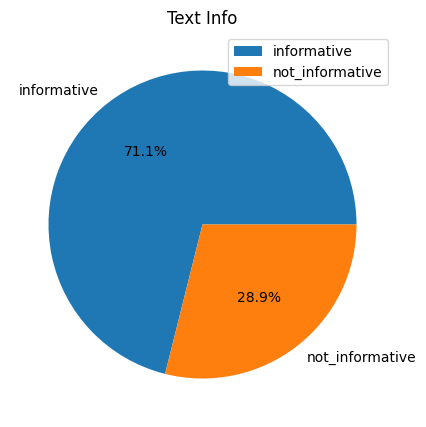

In [33]:
text = df['text_info'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(text, labels=text.index, autopct='%1.1f%%')
plt.title('Text Info')
plt.legend(labels=text.index)
plt.show()

Insight:

- 71% of the tweets are informative about disasters.
- 29% of the tweets are not informative about disasters.

#### Term Frequency Analysis

##### Tweets Character Length

**Character count for the raw data**

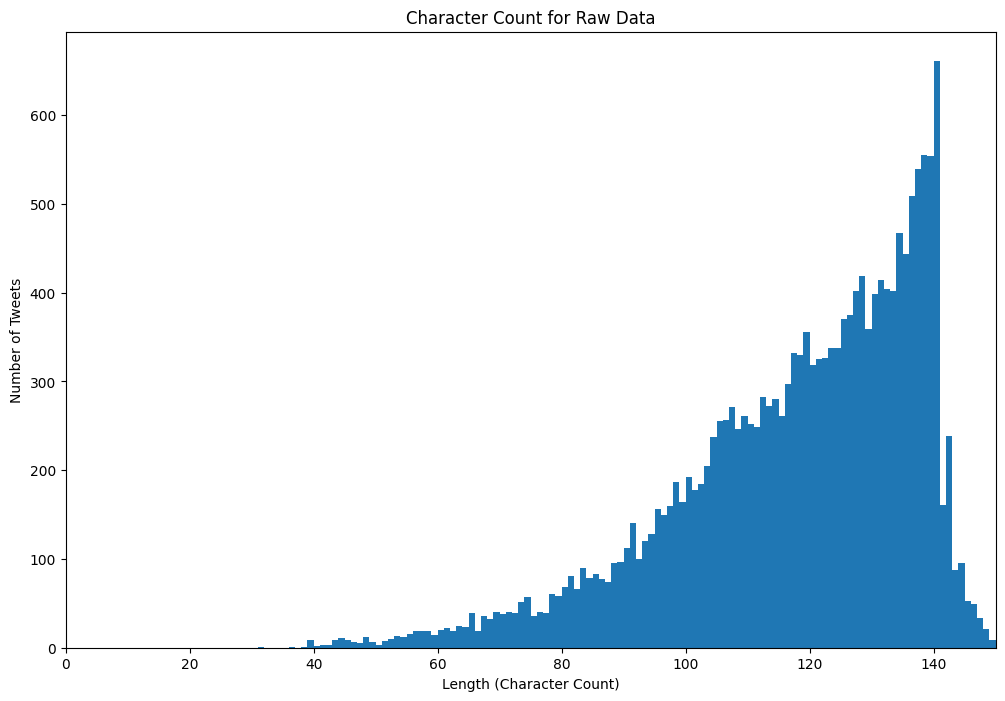

In [34]:
def length(string):
    return len(string)
df['length'] = df['tweet_text'].apply(length)


plt.figure(figsize=(12,8))
bins = 150
plt.hist(df['length'], bins=bins)
plt.title("Character Count for Raw Data")
plt.xlabel('Length (Character Count)')
plt.ylabel('Number of Tweets')
# plt.legend(loc='upper right')
plt.xlim(0,150)
# plt.grid()
plt.show();

Insights:

- The distribution of character counts in the raw tweets appears to be right-skewed, with a significant number of tweets having higher character counts near the maximum limit of the allowed tweet length (around 140 characters).
- Unlike a normal distribution, the central tendency (mean or median) is not as apparent in the raw data histogram.
- The majority of tweets seem to cluster around the higher end of the character count spectrum, closer to the maximum limit.
- The word counts range from nearly 0 to around 140-150 words.
- There is a gradual increase in the number of tweets as the character count increases, followed by a sharp peak near the upper limit.
- The raw data includes many tweets with high word counts, likely due to the presence of non-text elements like URLs, mentions, and hashtags.

**Character Frequent for clean data**

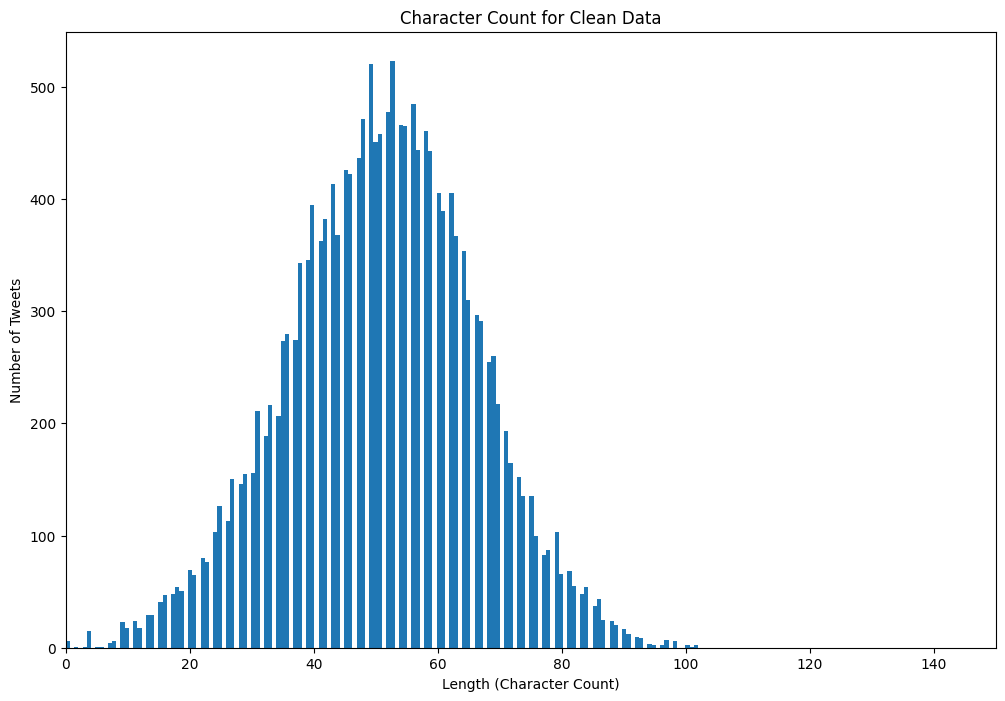

In [35]:
def clean_length(string):
    return len(string)
df['clean_length'] = df['cleanText'].apply(length)


plt.figure(figsize=(12,8))
bins = 150
plt.hist(df['clean_length'], bins=bins)
plt.title("Character Count for Clean Data")
plt.xlabel('Length (Character Count)')
plt.ylabel('Number of Tweets')
# plt.legend(loc='upper right')
plt.xlim(0,150)
plt.show();

Insight:

- The distribution of character counts in the tweets appears to be approximately normal (bell-shaped), with a slight skew to the right. This indicates that most tweets have a character count near the mean, with fewer tweets having very low or very high word counts.
- The peak of the distribution (mode) occurs around 50-60 charater per tweet, suggesting that the most common tweet length in your dataset is around this range.
- The central tendency indicates that a typical tweet in this dataset contains about 50-60 character.
- The word counts range from as low as nearly 0 to just over 100, with the majority of tweets containing between 20 and 80 character.
- There are very few tweets with character counts beyond 100 words, indicating that extremely long tweets are rare in this dataset.
- The relatively smooth and symmetrical shape of the histogram suggests that the dataset has been cleaned effectively, with consistent tweet lengths.

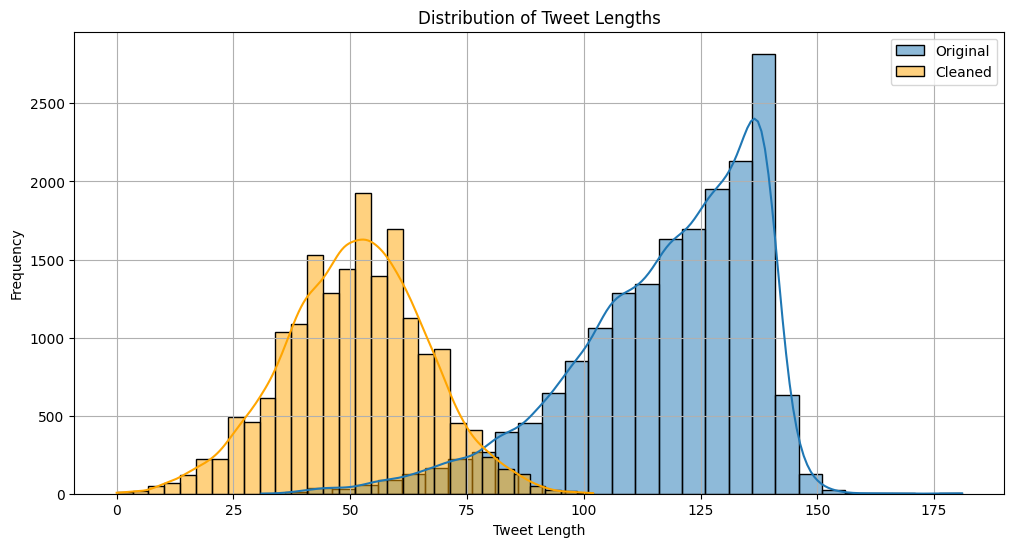

In [36]:
# Calculate the length of each tweet
df['tweet_length'] = df['tweet_text'].apply(len)
df['clean_tweet_length'] = df['cleanText'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(12, 6))
sns.histplot(df['tweet_length'], bins=30, kde=True, label='Original')
sns.histplot(df['clean_tweet_length'], bins=30, kde=True, label='Cleaned', color='orange')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid()
plt.legend()
plt.show()


##### Word Count Analysis

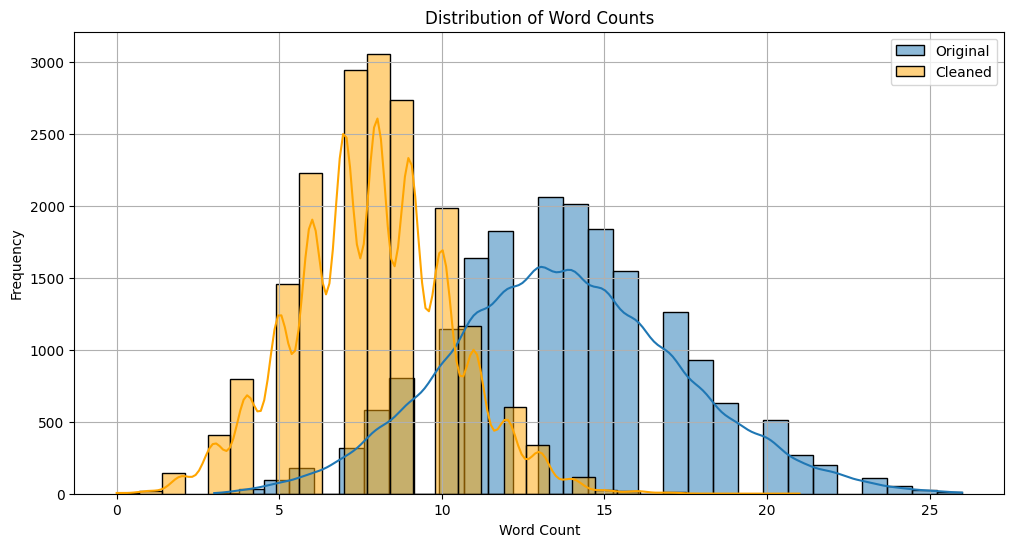

In [37]:
# Calculate word count for each tweet
df['word_count'] = df['tweet_text'].apply(lambda x: len(x.split()))
df['clean_word_count'] = df['cleanText'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=30, kde=True, label='Original')
sns.histplot(df['clean_word_count'], bins=30, kde=True, label='Cleaned', color='orange')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


##### Tweets Length by text-info

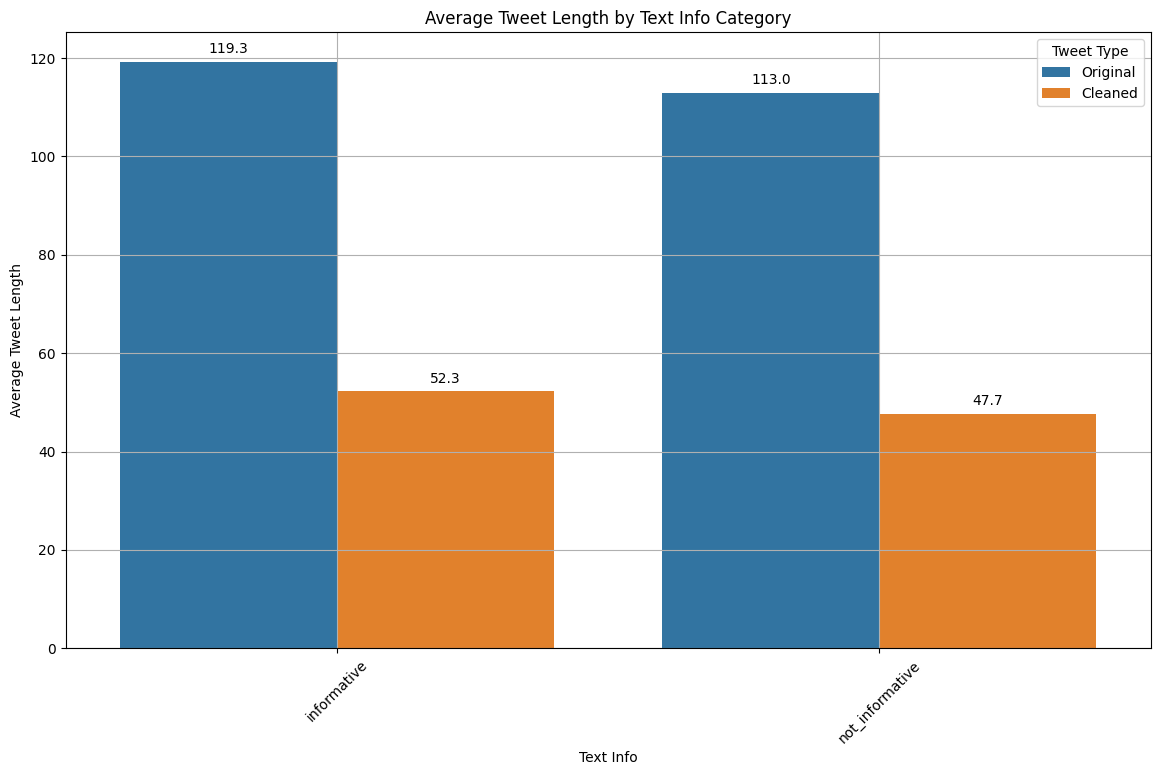

In [38]:
# Group by 'text_info' and calculate the average tweet length
length_by_category = df.groupby('text_info')[['tweet_length', 'clean_tweet_length']].mean().reset_index()

# Reshape the data for better visualization
length_by_category_melted = length_by_category.melt(id_vars='text_info', value_vars=['tweet_length', 'clean_tweet_length'], 
                                                    var_name='Type', value_name='Average Length')

# Rename 'Type' values for clarity
length_by_category_melted['Type'] = length_by_category_melted['Type'].replace({
    'tweet_length': 'Original',
    'clean_tweet_length': 'Cleaned'
})

# Plot the average tweet length by category
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='text_info', y='Average Length', hue='Type', data=length_by_category_melted)
plt.title('Average Tweet Length by Text Info Category')
plt.xlabel('Text Info')
plt.ylabel('Average Tweet Length')
plt.legend(title='Tweet Type')
plt.xticks(rotation=45)

# Annotate the bar plot with values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Add annotation only if height is greater than 0
        barplot.annotate(format(height, '.1f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha = 'center', va = 'center',
                         xytext = (0, 9), textcoords='offset points')

plt.grid()
plt.show()


##### Most Common Stop words

In [39]:
# filter out words by English words.
stop=set(stopwords.words('english'))

**Raw Data Stop Word**

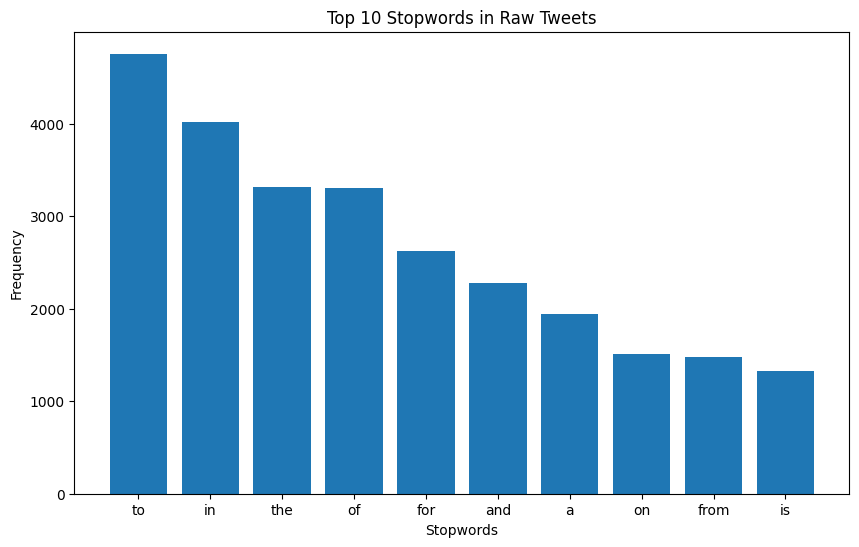

In [40]:
# Tokenize the text
new = df['tweet_text'].str.split()
new = new.values.tolist()


# Flatten the list of lists into a single list of words
corpus = [word for sublist in new for word in sublist]


# Create a dictionary to count stopword occurrences
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        

# Get the top 10 stopwords by frequency
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)


# Plot the bar chart
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title("Top 10 Stopwords in Raw Tweets")
plt.xlabel("Stopwords")
plt.ylabel("Frequency");

Insights:

- The word "to" is the most frequent stopword, appearing over 4500 times.
- This is followed by "in," "the," "of," "for," "and," "a," "on," "from," and "is."
- The top stopwords are very common in the English language and are typically used to form the structure of sentences.
- The high frequency of these stopwords suggests that they do not carry significant semantic meaning and are primarily used for grammatical purposes.

**Clean Data Stop Word**

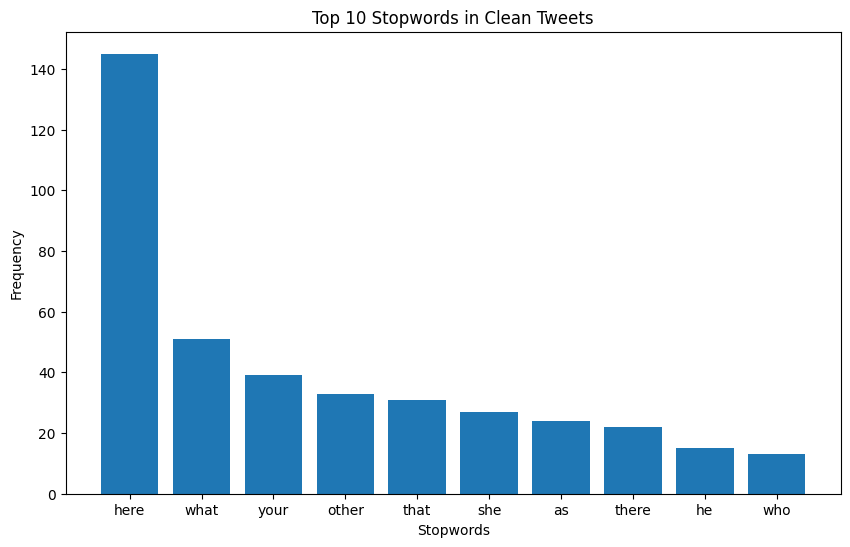

In [41]:
# Tokenize the text
new_clean = df['cleanText'].str.split()
new_clean = new_clean.values.tolist()


# Flatten the list of lists into a single list of words
corpus_clean = [word for sublist in new_clean for word in sublist]


# Create a dictionary to count stopword occurrences
dic = defaultdict(int)
for word in corpus_clean:
    if word in stop:
        dic[word] += 1
        

# Get the top 10 stopwords by frequency
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)


# Plot the bar chart
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title("Top 10 Stopwords in Clean Tweets")
plt.xlabel("Stopwords")
plt.ylabel("Frequency");

Insights:

- The most frequent stopword is "other," appearing just over 30 times.
- This is followed by "here," "as," "your," "what," "that," "there," "so," "own," and "down."
- Compared to the initial analysis of raw data, these stopwords are less frequent, indicating effective data cleaning and removal of many common stopwords.
- The reduced frequency of stopwords in the cleaned data indicates an improvement in data quality, as non-informative words have been significantly reduced. This allows for a clearer focus on the meaningful content of the tweets.

##### Most Common Words

**Raw Tweet**

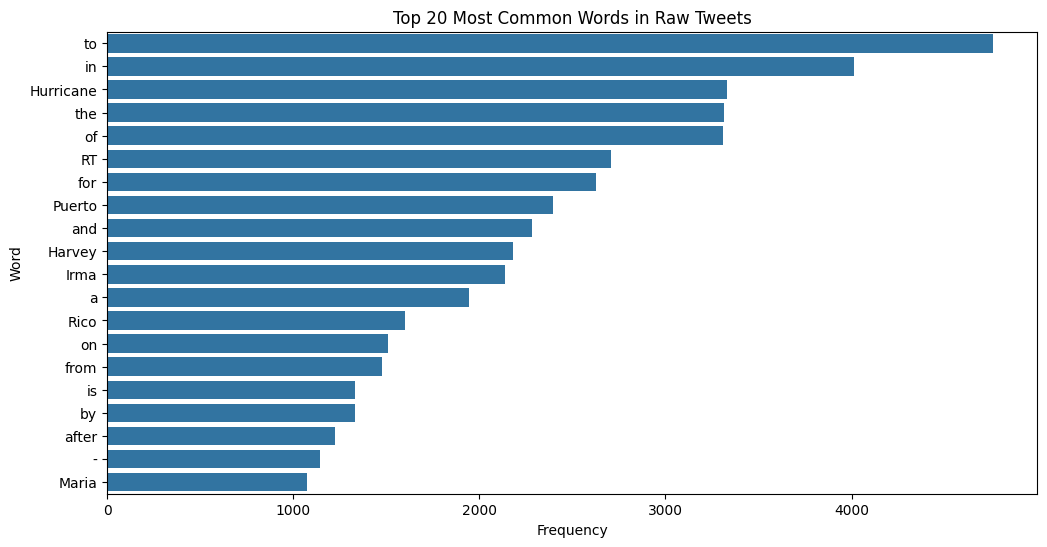

In [42]:
# Combine all eaw tweets into one string
all_raw_words = ' '.join(df['tweet_text'])

# Display the top 20 most common raw words
word_raw_counts = Counter(all_raw_words.split())
common_raw_words = word_raw_counts.most_common(20)
common_raw_words_df = pd.DataFrame(common_raw_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_raw_words_df)
plt.title('Top 20 Most Common Words in Raw Tweets')
plt.show()

**Cleaned Tweet**

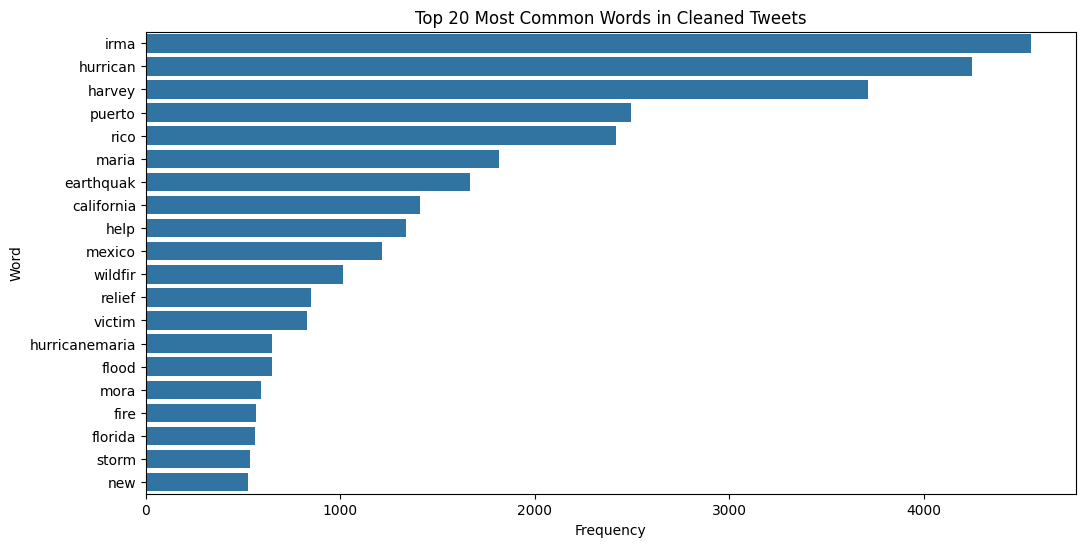

In [43]:
# Combine all cleaned tweets into one string
all_words = ' '.join(df['cleanText'])


# Display the top 20 most common words
word_counts = Counter(all_words.split())
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df)
plt.title('Top 20 Most Common Words in Cleaned Tweets')
plt.show()


##### N-gram Analysis

**Raw N-gram Analysis**

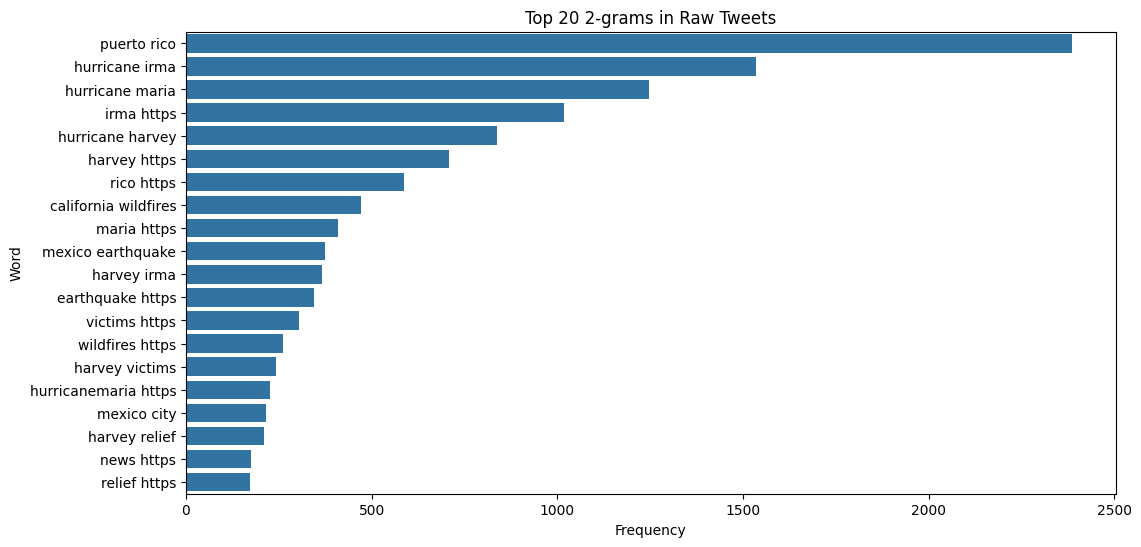

In [44]:
# Define a function to plot n-grams
def plot_ngrams(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_raw_words = words_freq[:20]
    common_raw_words_df = pd.DataFrame(common_raw_words, columns=['Word', 'Frequency'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=common_raw_words_df)
    plt.title(f'Top 20 {n}-grams in Raw Tweets')
    plt.show()

# Plot bigrams and trigrams
plot_ngrams(df['tweet_text'], n=2)

**Cleaned N-gram Analysis**

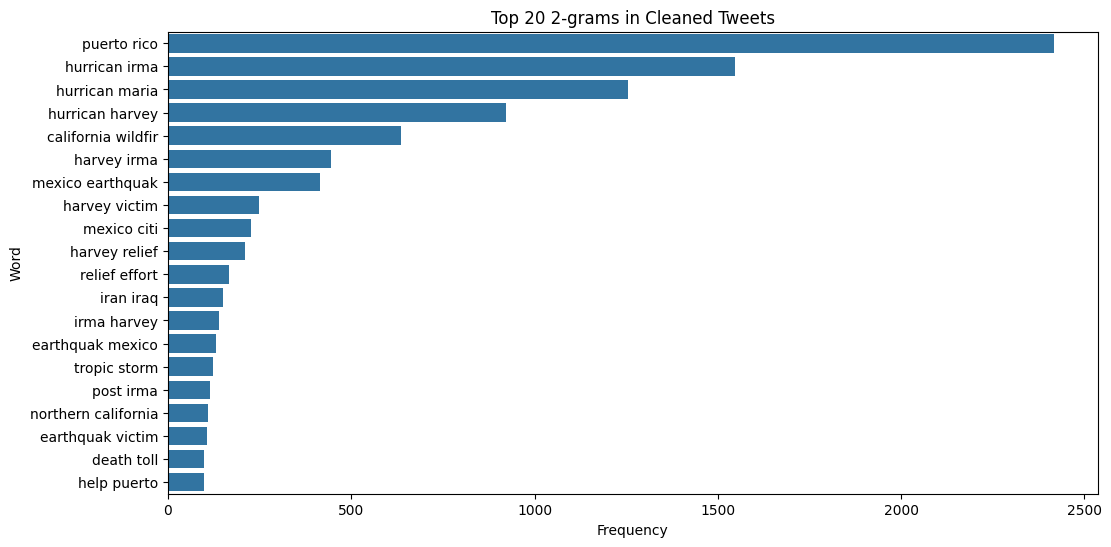

In [45]:
# Define a function to plot n-grams
def plot_ngrams(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:20]
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title(f'Top 20 {n}-grams in Cleaned Tweets')
    plt.show()

# Plot bigrams and trigrams
plot_ngrams(df['cleanText'], n=2)
# plot_ngrams(df['cleanText'], n=3)


##### N-gram Analysis by 'text_info'

**Raw N-gram Analysis by text_info**

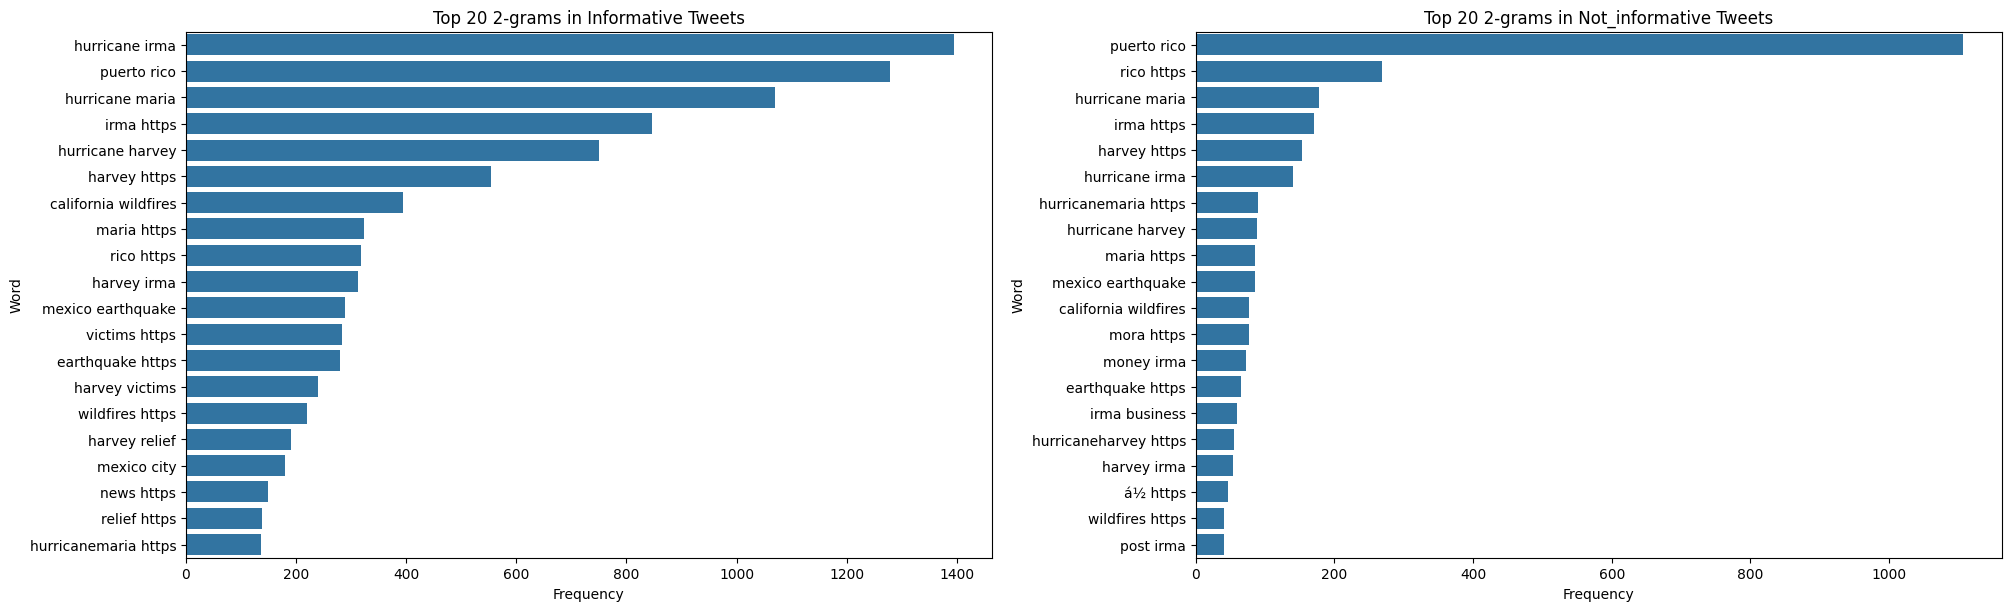

In [46]:
# Function to plot n-grams for a given category
def plot_ngrams_by_category(ax, df, category, n=2):
    # Filter the DataFrame for the specified category
    category_df = df[df['text_info'] == category]
    
    # Extract the text corpus
    corpus = category_df['tweet_text'].tolist()
    
    # Vectorize the corpus and calculate n-grams
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:20]
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    
    # Plot the n-grams
    sns.barplot(x='Frequency', y='Word', data=common_words_df, ax=ax)
    ax.set_title(f'Top 20 {n}-grams in {category.capitalize()} Tweets')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')

# Plot n-grams for each category in 'text_info'
categories = df['text_info'].unique()
num_categories = len(categories)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=(num_categories + 1) // 2, ncols=2, figsize=(20, num_categories * 3), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate the plots
for i, category in enumerate(categories):
    plot_ngrams_by_category(axes[i], df, category, n=2)  # Adjust n as needed for bigrams or trigrams

# Remove any unused subplots
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

plt.show()

**Cleaned N-gram Analysis by text_info**

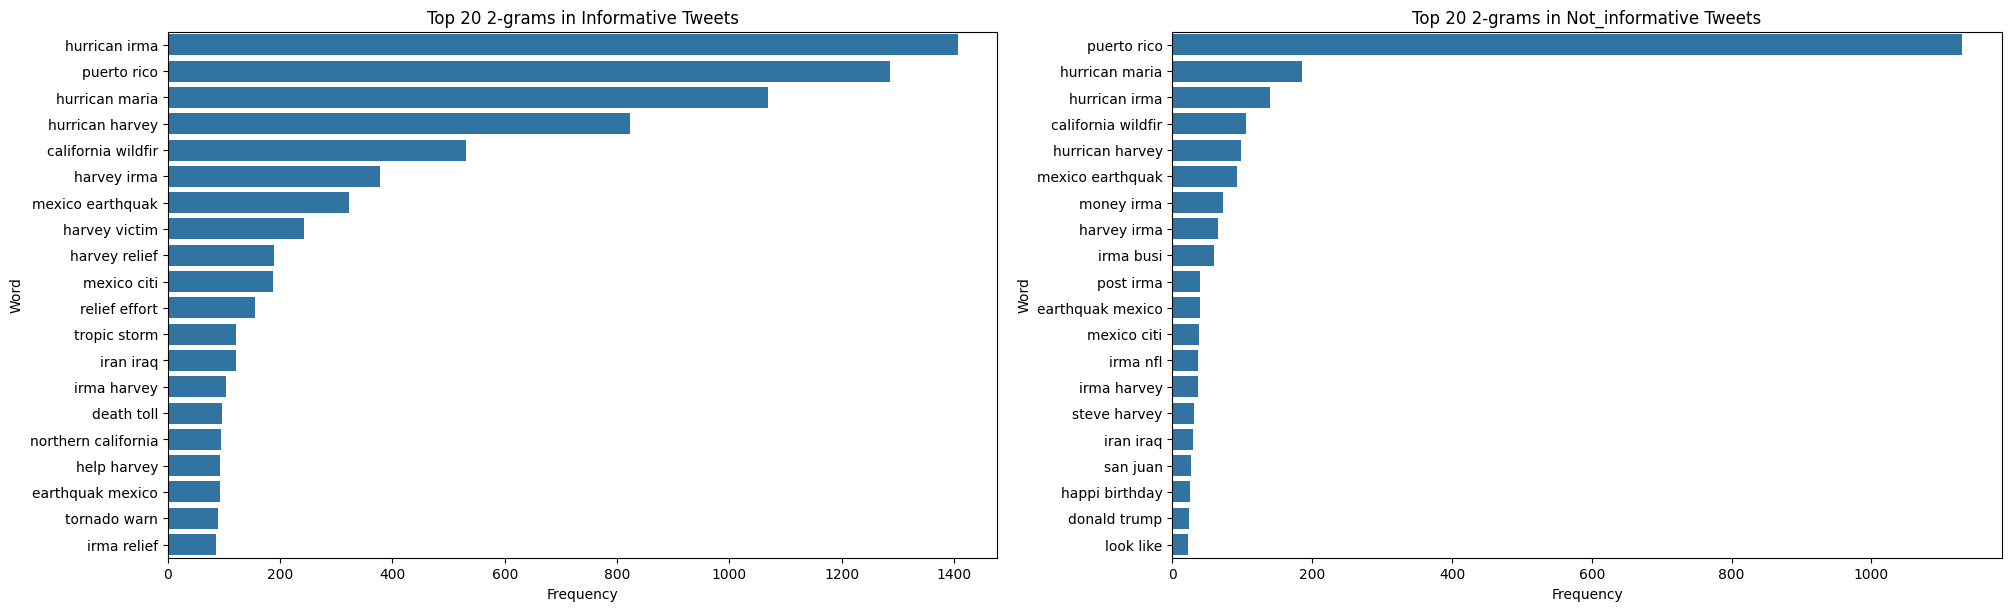

In [47]:
# Function to plot n-grams for a given category
def plot_ngrams_by_category(ax, df, category, n=2):
    # Filter the DataFrame for the specified category
    category_df = df[df['text_info'] == category]
    
    # Extract the text corpus
    corpus = category_df['cleanText'].tolist()
    
    # Vectorize the corpus and calculate n-grams
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:20]
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    
    # Plot the n-grams
    sns.barplot(x='Frequency', y='Word', data=common_words_df, ax=ax)
    ax.set_title(f'Top 20 {n}-grams in {category.capitalize()} Tweets')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')

# Plot n-grams for each category in 'text_info'
categories = df['text_info'].unique()
num_categories = len(categories)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=(num_categories + 1) // 2, ncols=2, figsize=(20, num_categories * 3), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate the plots
for i, category in enumerate(categories):
    plot_ngrams_by_category(axes[i], df, category, n=2)  # Adjust n as needed for bigrams or trigrams

# Remove any unused subplots
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

plt.show()

##### Tri-gram Analysis

**Raw Tri-gram Analysis**

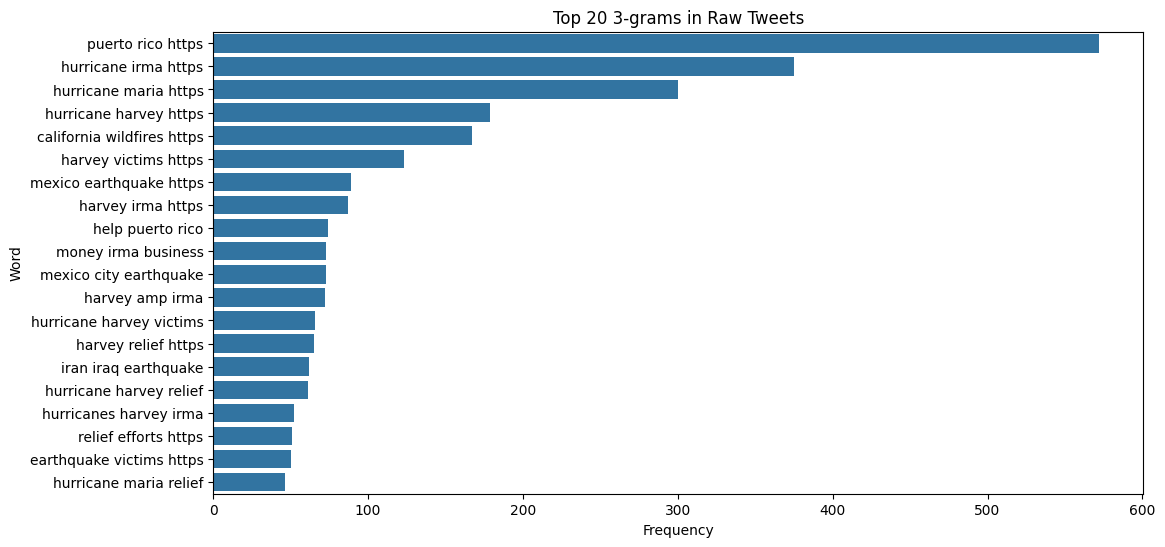

In [48]:
# Define a function to plot tri-grams
def plot_trigrams(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_raw_words = words_freq[:20]
    common_raw_words_df = pd.DataFrame(common_raw_words, columns=['Word', 'Frequency'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=common_raw_words_df)
    plt.title(f'Top 20 {n}-grams in Raw Tweets')
    plt.show()

# Plot bigrams and trigrams
plot_trigrams(df['tweet_text'], n=3)

**Cleaned Tri-gram Analysis**

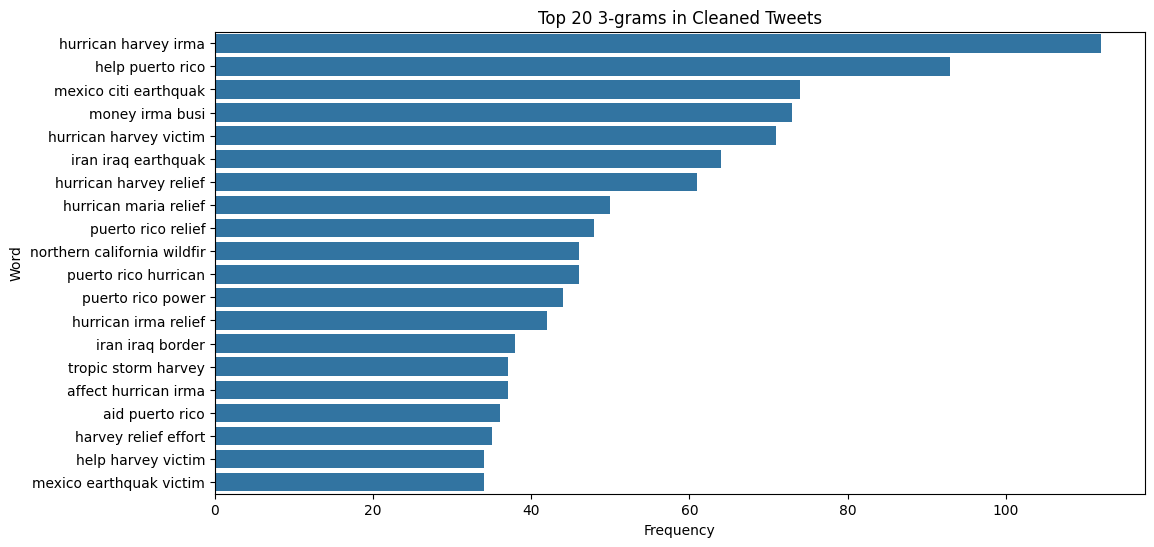

In [49]:
# Define a function to plot tri-grams
def plot_trigrams(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:20]
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title(f'Top 20 {n}-grams in Cleaned Tweets')
    plt.show()

# Plot bigrams and trigrams
plot_trigrams(df['cleanText'], n=3)

##### Hashtag Analysis 

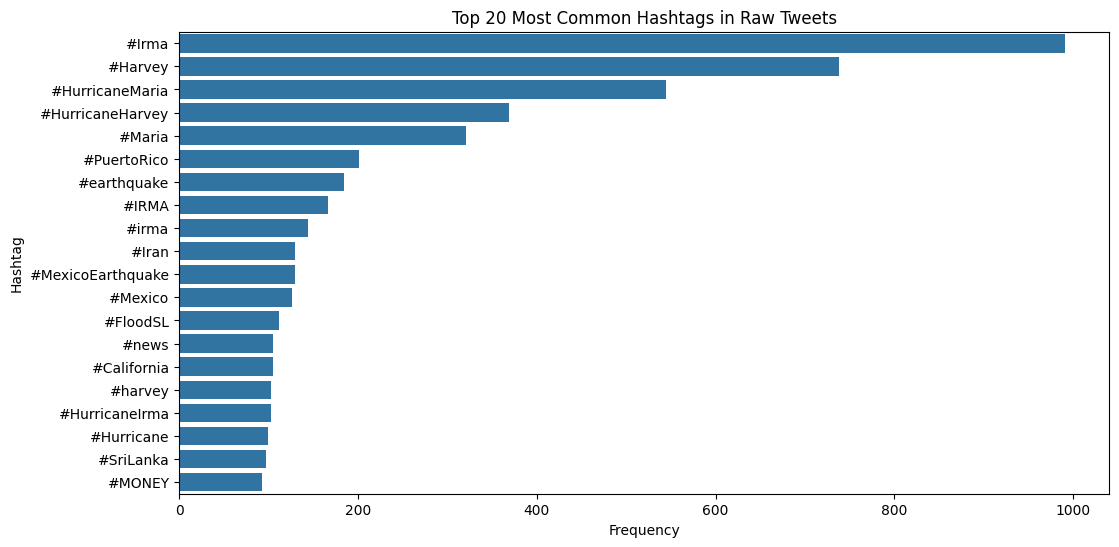

In [50]:
# Extract hashtags from the cleaned text
df['hashtags'] = df['tweet_text'].apply(lambda x: re.findall(r'#\w+', x))

# Flatten the list of hashtags
all_hashtags = [hashtag for sublist in df['hashtags'] for hashtag in sublist]

# Count the occurrences of each hashtag
hashtag_counts = Counter(all_hashtags)
common_hashtags = hashtag_counts.most_common(20)
common_hashtags_df = pd.DataFrame(common_hashtags, columns=['Hashtag', 'Frequency'])

# Plot the most common hashtags
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Hashtag', data=common_hashtags_df)
plt.title('Top 20 Most Common Hashtags in Raw Tweets')
plt.show()


#### Word Cloud

##### Raw Tweets

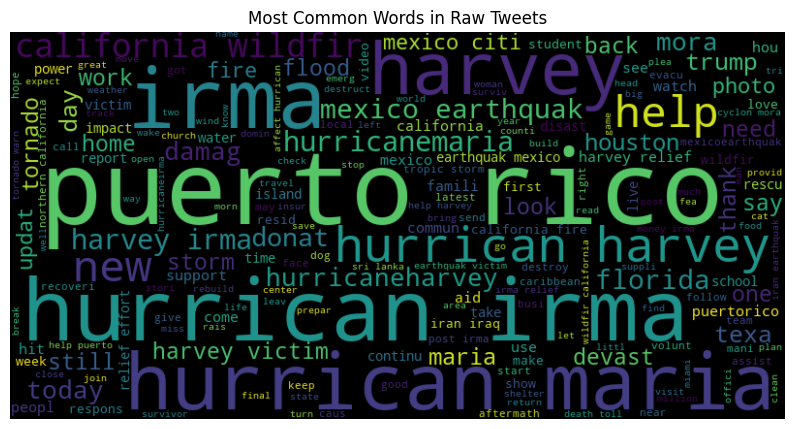

In [51]:
# Combine all raw tweets into one string
all_raw_words = ' '.join(df['tweet_text'])


# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Raw Tweets')
plt.show()

##### Cleaned Tweets

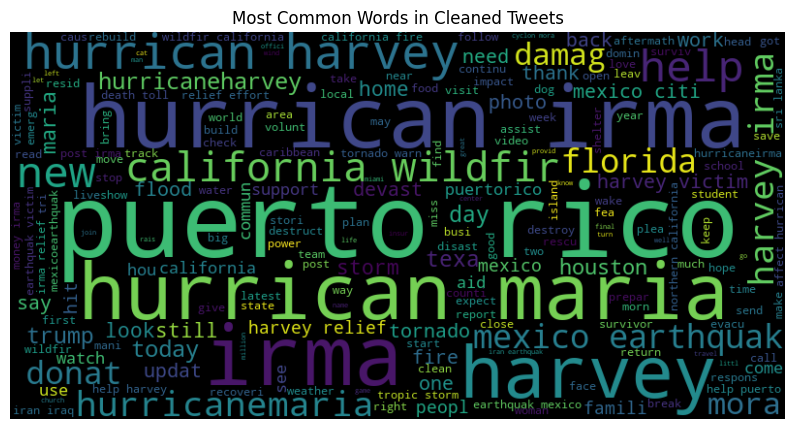

In [52]:
# Combine all cleaned tweets into one string
all_words = ' '.join(df['cleanText'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Cleaned Tweets')
plt.show()


##### Word Cloud by 'text_info

**Raw by 'text_info'**

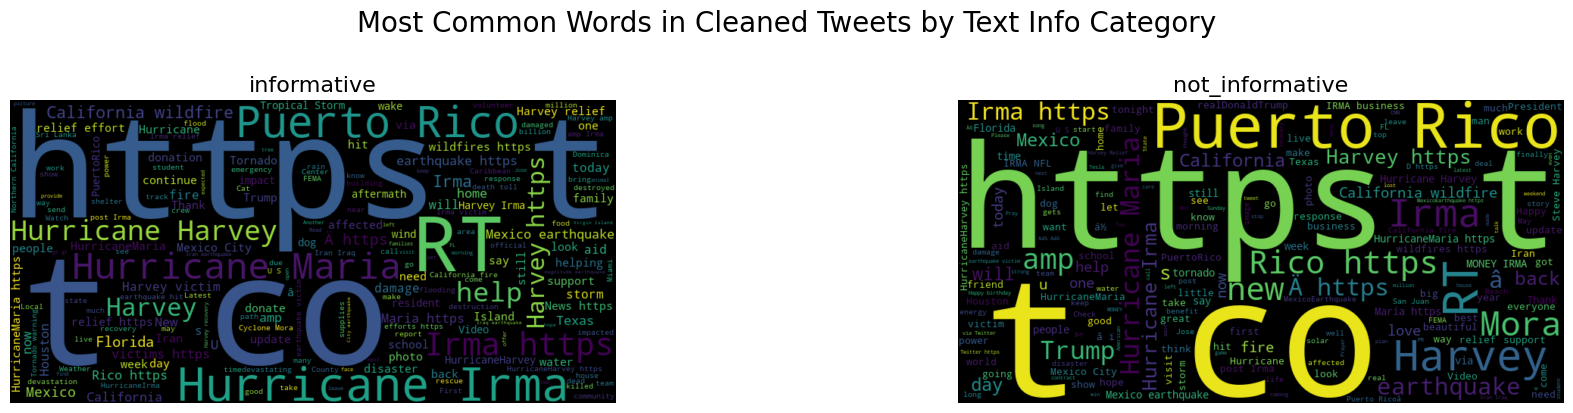

In [53]:
# Get unique text_info categories
categories = df['text_info'].unique()

# Set the number of rows and columns for the subplots
rows = (len(categories) + 1) // 2
cols = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
fig.suptitle('Most Common Words in Cleaned Tweets by Text Info Category', fontsize=20, y=1.02)

# Flatten axes if it is 2-dimensional
if rows * cols == 1:
    axes = [axes]  # If there's only one subplot, make it a list
else:
    axes = axes.flatten()

# Generate and plot a word cloud for each category
for i, category in enumerate(categories):
    # Combine all cleaned tweets in this category into one string
    category_words = ' '.join(df[df['text_info'] == category]['tweet_text'])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(category_words)
    
    # Determine subplot position
    ax = axes[i]
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(category, fontsize=16)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


**Cleaned by 'text_info'**

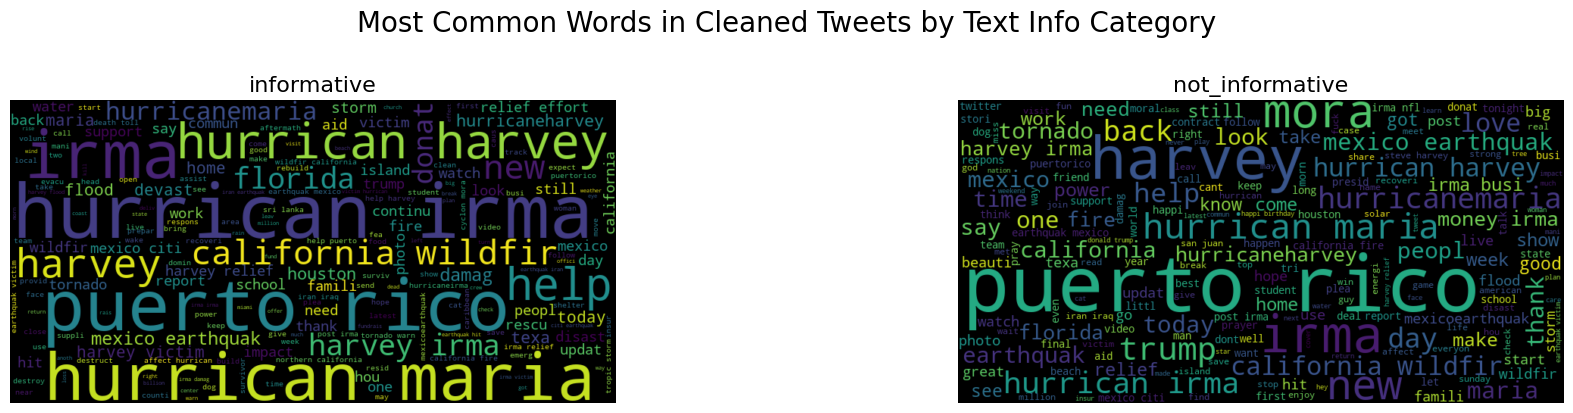

In [54]:
# Get unique text_info categories
categories = df['text_info'].unique()

# Set the number of rows and columns for the subplots
rows = (len(categories) + 1) // 2
cols = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
fig.suptitle('Most Common Words in Cleaned Tweets by Text Info Category', fontsize=20, y=1.02)

# Flatten axes if it is 2-dimensional
if rows * cols == 1:
    axes = [axes]  # If there's only one subplot, make it a list
else:
    axes = axes.flatten()

# Generate and plot a word cloud for each category
for i, category in enumerate(categories):
    # Combine all cleaned tweets in this category into one string
    category_words = ' '.join(df[df['text_info'] == category]['cleanText'])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(category_words)
    
    # Determine subplot position
    ax = axes[i]
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(category, fontsize=16)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


#### Topic Modeling

In [55]:
# Vectorize the cleaned text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleanText'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 1:
harvey irma hurrican help relief donat puerto victim rico effort
Topic 2:
irma hurrican mora tornado maria harvey storm hurricanemaria damag puertorico
Topic 3:
earthquak mexico hurrican iran maria irma citi iraq hit news
Topic 4:
california wildfir flood harvey irma hurrican hurricaneharvey northern houston srilanka
Topic 5:
puerto rico irma hurrican harvey help busi rais money relief


**Topic Modeling by 'text_info'**

In [56]:
# # Define a function to perform topic modeling for each group
# def topic_modeling_by_group(group, n_topics=5, n_words=10):
#     print(f"\nTopic modeling for text_info: {group.name}")
    
#     # Vectorize the cleaned text
#     tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
#     tfidf_matrix = tfidf_vectorizer.fit_transform(group['cleanText'])
    
#     # Fit the LDA model
#     lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
#     lda.fit(tfidf_matrix)
    
#     # Display the top words for each topic
#     feature_names = tfidf_vectorizer.get_feature_names_out()
#     for topic_idx, topic in enumerate(lda.components_):
#         print(f"Topic {topic_idx + 1}:")
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))

# # Group by 'text_info' and apply the topic modeling function
# df.groupby('text_info').apply(topic_modeling_by_group)


In [57]:
# Define a function to perform topic modeling and return the top words for each topic
def topic_modeling(group, n_topics=5, n_words=10):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(group['cleanText'])
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])
        topics.append((f"Topic {topic_idx + 1}", top_words))
    return topics

# Perform topic modeling for informative and not_informative groups
informative_topics = topic_modeling(df[df['text_info'] == 'informative'])
not_informative_topics = topic_modeling(df[df['text_info'] == 'not_informative'])

# Display the topics side by side with horizontal space between them
print("Topic Modeling for text_info: Informative".ljust(50) + " " * 10 + "Topic Modeling for text_info: Not Informative")
print("=" * 50 + " " * 10 + "=" * 50)

for idx in range(max(len(informative_topics), len(not_informative_topics))):
    informative_topic = informative_topics[idx] if idx < len(informative_topics) else ("", "")
    not_informative_topic = not_informative_topics[idx] if idx < len(not_informative_topics) else ("", "")
    
    print(f"{informative_topic[0]}: {informative_topic[1]}".ljust(50) + " " * 10 + f"{not_informative_topic[0]}: {not_informative_topic[1]}")

Topic Modeling for text_info: Informative                   Topic Modeling for text_info: Not Informative
==================================================          ==================================================
Topic 1: harvey irma hurrican flood help affect houston florida work victim          Topic 1: irma harvey hurrican mora work happi hurricaneharvey maria money busi
Topic 2: california wildfir earthquak iran iraq photo death toll northern harvey          Topic 2: puerto rico harvey mora irma hurricanemaria power say trump updat
Topic 3: irma hurrican harvey maria relief island puerto rico disast path          Topic 3: earthquak mexico maria hurrican post irma harvey mora famili rico
Topic 4: mexico earthquak hurrican maria irma tornado storm citi warn tropic          Topic 4: puerto rico harvey help trump earthquak hurrican plea iran moral
Topic 5: puerto rico help harvey hurrican irma relief victim donat hurricanemaria          Topic 5: california wildfir rico puerto harve

**Add Topic Features to DataFrame**

In [58]:
# Get the topic distribution for each document
topic_distributions = lda.transform(tfidf_matrix)

# Create a DataFrame for the topic distributions
topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i+1}' for i in range(topic_distributions.shape[1])])

# Concatenate the original DataFrame with the topic distributions
df = pd.concat([df, topic_df], axis=1)

# Display the updated DataFrame
df.head(2)


,text_info,tweet_text,cleanText,length,clean_length,tweet_length,clean_tweet_length,word_count,clean_word_count,hashtags,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,informative,RT @Gizmodo: Wildfires raging through Northern...,wildfir rage northern california terrifi,120,40,120,40,11,5,[],0.068478,0.068478,0.068479,0.726086,0.06848
1,informative,PHOTOS: Deadly wildfires rage in California ht...,photo deadli wildfir rage california,91,36,91,36,8,5,[],0.063583,0.063398,0.064657,0.744412,0.06395


### Feature Extraction

Before performing the feature extraction, we will need to split the dataset.

In [59]:
df.head(2)

,text_info,tweet_text,cleanText,length,clean_length,tweet_length,clean_tweet_length,word_count,clean_word_count,hashtags,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,informative,RT @Gizmodo: Wildfires raging through Northern...,wildfir rage northern california terrifi,120,40,120,40,11,5,[],0.068478,0.068478,0.068479,0.726086,0.06848
1,informative,PHOTOS: Deadly wildfires rage in California ht...,photo deadli wildfir rage california,91,36,91,36,8,5,[],0.063583,0.063398,0.064657,0.744412,0.06395


In [60]:
# Define the mapping for labels
mapping = {'informative': 1, 'not_informative': 0}

# Apply the mapping to the 'text_info' column
df['label'] = df['text_info'].map(mapping)

In [61]:

# Define features (X) and labels (y)
X = df['cleanText']
y = df['label']

In [62]:
# Step 1: Split the data into training, test, and val sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [63]:
# Step 2: Initialize TF-IDF Vectorizer and fit on training data
tfidf_vectorizer = TfidfVectorizer(
                max_features=1000,
                sublinear_tf=True,
                min_df=10,
                norm='l2',
                ngram_range=(1, 2),
                stop_words='english'
            )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [64]:
# Step 3: Transform the validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [65]:
# Convert to DataFrame for easy manipulation
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_train_tfidf_df.head(2)

,account,act,action,activ,actual,adopt,advisori,affect,affect harvey,affect hurrican,...,work,worker,world,wors,worst,ye,year,year old,yesterday,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Selection

##### Logistic Regression

In [118]:
# Initialize and train the classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [119]:
# Evaluate on the validation set
y_val_pred = clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.76      0.49      0.60      1075
           1       0.81      0.94      0.87      2541

    accuracy                           0.80      3616
   macro avg       0.79      0.71      0.73      3616
weighted avg       0.80      0.80      0.79      3616



In [120]:
# Evaluate on the test set
y_test_pred_clf = clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_clf))


Test Set Evaluation
              precision    recall  f1-score   support

           0       0.79      0.48      0.59      1040
           1       0.82      0.95      0.88      2577

    accuracy                           0.81      3617
   macro avg       0.80      0.71      0.74      3617
weighted avg       0.81      0.81      0.80      3617



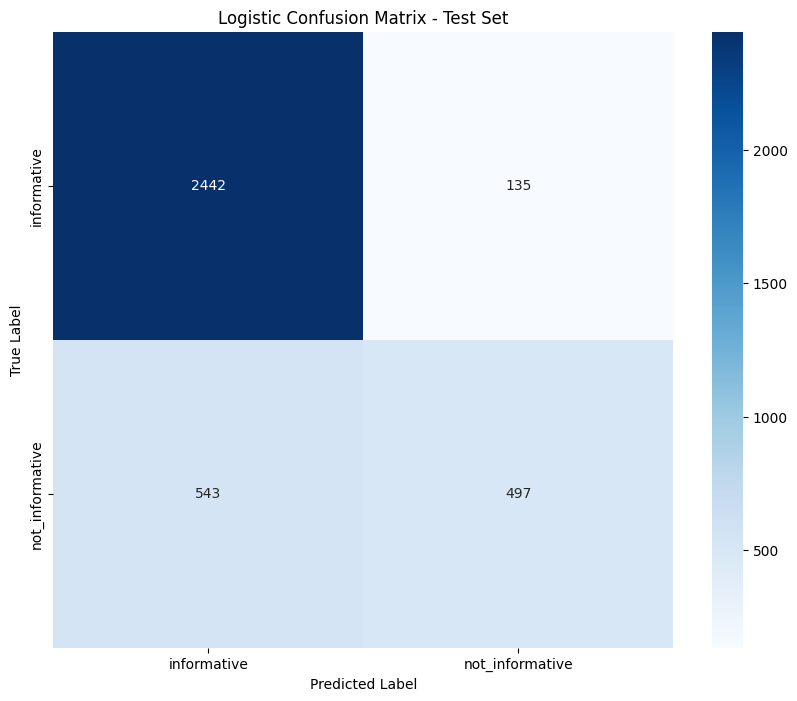

In [121]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_clf_matrix = confusion_matrix(y_test, y_test_pred_clf, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Logistic Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Insights**

- High Recall for Informative Tweets (Class 1): The model has a high recall (95%) for informative tweets, meaning it correctly identifies most of the informative tweets.

- Moderate Precision for Informative Tweets (Class 1): The precision (82%) indicates that when the model predicts a tweet as informative, it is quite likely to be correct, but there are still some false positives.

- Low Recall for Not Informative Tweets (Class 0): The recall (48%) for not informative tweets is relatively low, meaning the model often predicts not informative tweets incorrectly as informative (higher false positives).

- Overall Accuracy: The model's overall accuracy is approximately 81%, indicating it performs well but has room for improvement, especially in correctly identifying not informative tweets.

- Class Imbalance Handling: The higher recall and precision for informative tweets suggest the model is more effective at identifying informative tweets, which might be due to a higher proportion of informative tweets in the dataset.

##### K-Nearest Neighbors

In [70]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [71]:
# Evaluate on the validation set
y_val_pred = knn.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.45      0.67      0.54      1075
           1       0.83      0.66      0.73      2541

    accuracy                           0.66      3616
   macro avg       0.64      0.67      0.64      3616
weighted avg       0.72      0.66      0.68      3616



In [72]:
# Evaluate on the test set
y_test_pred_knn = knn.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_knn))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.46      0.68      0.55      1040
           1       0.84      0.68      0.75      2577

    accuracy                           0.68      3617
   macro avg       0.65      0.68      0.65      3617
weighted avg       0.73      0.68      0.69      3617



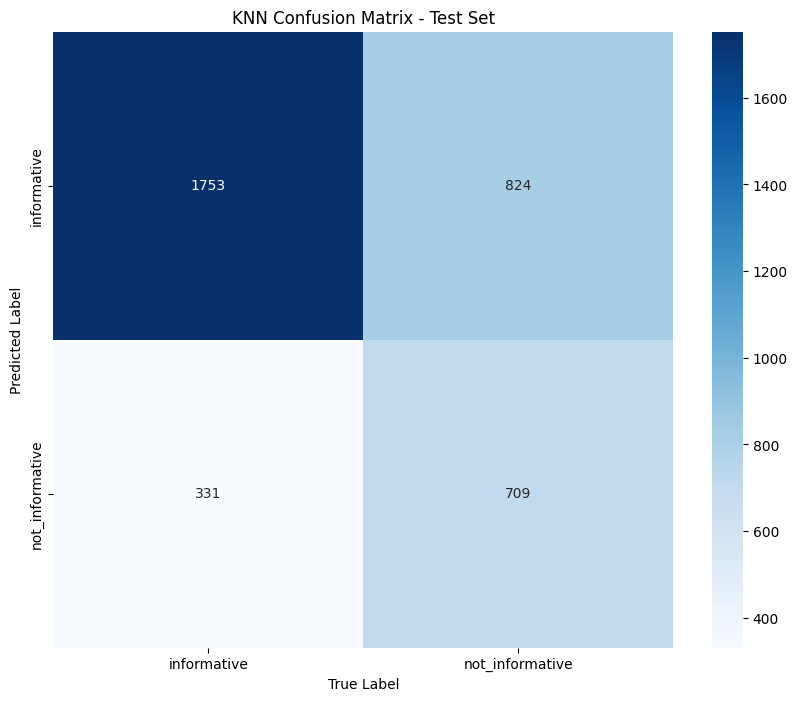

In [73]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_knn_matrix = confusion_matrix(y_test, y_test_pred_knn, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_knn_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- High Recall for Informative Tweets: The model has a high recall (84.1%) for informative tweets, meaning it correctly identifies most of the informative tweets.

- Moderate Precision for Informative Tweets: The precision (68.0%) indicates that while the model identifies most informative tweets, there is a moderate number of false positives.

- False Positive Rate: The number of false positives (824) is significant, suggesting the model sometimes incorrectly labels not_informative tweets as informative.

- False Negative Rate: The false negatives (331) are relatively lower, indicating the model misses fewer informative tweets compared to false positives.

- Overall Accuracy: With an accuracy of approximately 68.1%, the model's performance is moderate. The lower accuracy suggests that the model has room for improvement, particularly in reducing false positives.

##### Naive Bayes

In [74]:
# Initialize and train the Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [75]:
# Evaluate on the validation set
y_val_pred = nb_clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.80      0.39      0.52      1075
           1       0.79      0.96      0.86      2541

    accuracy                           0.79      3616
   macro avg       0.79      0.67      0.69      3616
weighted avg       0.79      0.79      0.76      3616



In [76]:
# Evaluate on the test set
y_test_pred_nb = nb_clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_nb))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.80      0.40      0.53      1040
           1       0.80      0.96      0.87      2577

    accuracy                           0.80      3617
   macro avg       0.80      0.68      0.70      3617
weighted avg       0.80      0.80      0.77      3617



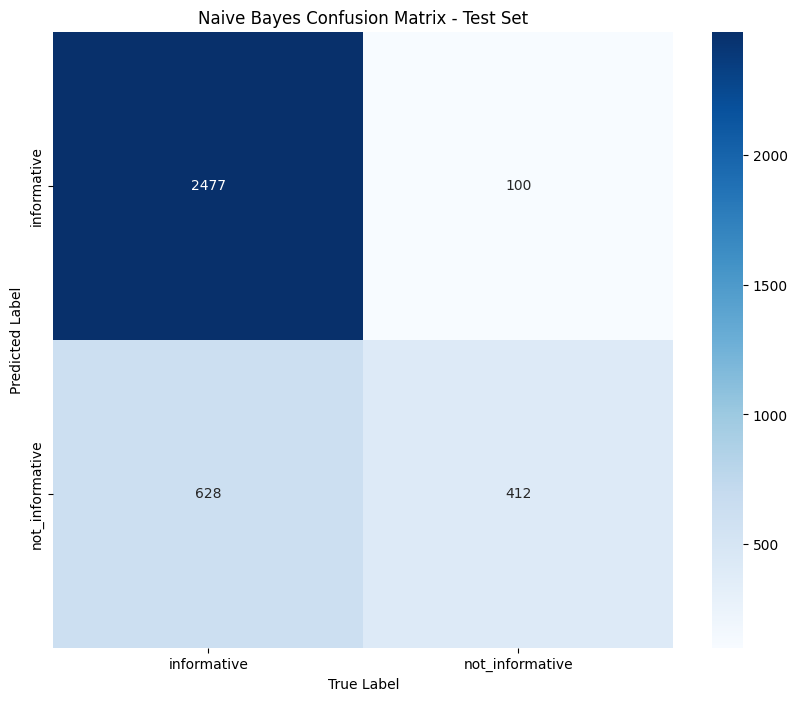

In [77]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_nb_clf_matrix = confusion_matrix(y_test, y_test_pred_nb, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_nb_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Naive Bayes Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- Moderate Recall for Informative Tweets (Class 1): The recall (96%) indicates that the model correctly identifies a significant portion of the actual informative tweets, but there are still some that it misses (higher false negatives).

- Moderate Precision for Informative Tweets (Class 1): The precision (80%) indicates that the model is quite likely to be correct when it predicts a tweet as informative, but there are still some false positives.

- False Positive Rate: The number of false positives (100) is relatively low, suggesting the model rarely misclassifies not_informative tweets as informative.

- False Negative Rate: The false negatives (628) are relatively higher, indicating that the model often misses informative tweets and incorrectly predicts them as not_informative.

- Overall Accuracy: With an accuracy of approximately 80%, the model performs well, but there is room for improvement, especially in improving the recall of informative tweets.

##### Random Forest

In [78]:
# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [79]:
# Evaluate on the validation set
y_val_pred = rf_clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1075
           1       0.83      0.93      0.88      2541

    accuracy                           0.82      3616
   macro avg       0.80      0.75      0.76      3616
weighted avg       0.81      0.82      0.81      3616



In [80]:
# Evaluate on the test set
y_test_pred_rf = rf_clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_rf))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.80      0.57      0.67      1040
           1       0.85      0.94      0.89      2577

    accuracy                           0.84      3617
   macro avg       0.82      0.76      0.78      3617
weighted avg       0.83      0.84      0.83      3617



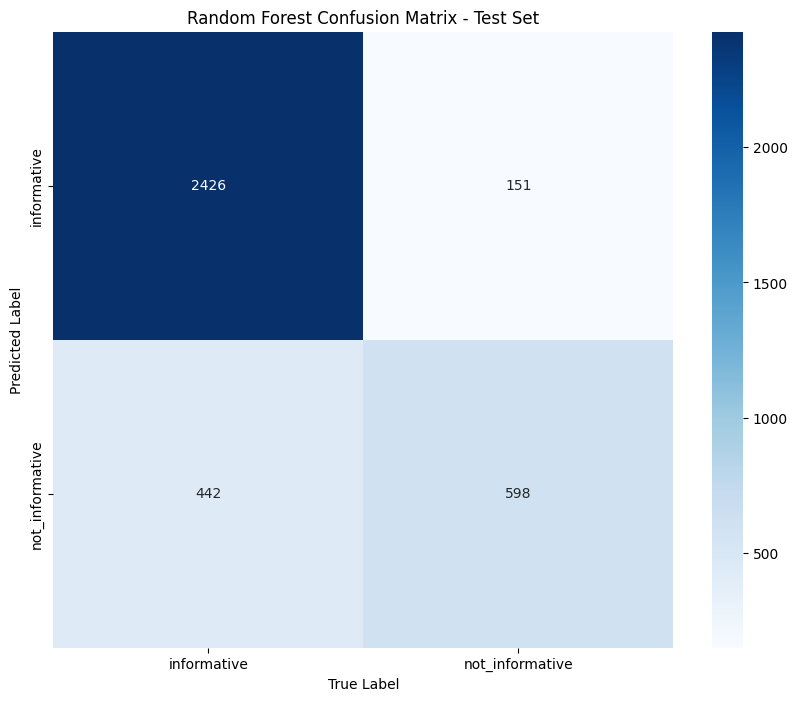

In [81]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_rf_clf_matrix = confusion_matrix(y_test, y_test_pred_rf, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_rf_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- Moderate Precision and Recall for Not Informative Tweets (Class 0): The precision (0.80) and recall (0.57) for not informative tweets indicate that the model moderately identifies not informative tweets correctly but has room for improvement.

- High Precision and Recall for Informative Tweets (Class 1): The precision (0.85) and recall (0.94) for informative tweets indicate that the model is very effective in identifying informative tweets.

- False Positive Rate: The number of false positives (151) is relatively low, suggesting the model rarely misclassifies not informative tweets as informative.

- False Negative Rate: The false negatives (442) indicate that the model sometimes misses informative tweets and incorrectly predicts them as not informative.

- Overall Accuracy: With an accuracy of approximately 84%, the model performs well but has room for improvement, especially in improving the recall of not informative tweets.

##### Gradient Boosting

In [82]:

# Initialize and train the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(random_state=42)

In [83]:
# Evaluate on the validation set
y_val_pred = gb_clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.79      0.31      0.45      1075
           1       0.77      0.96      0.86      2541

    accuracy                           0.77      3616
   macro avg       0.78      0.64      0.65      3616
weighted avg       0.77      0.77      0.73      3616



In [84]:
# Evaluate on the test set
y_test_pred_gb = gb_clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_gb))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.83      0.31      0.45      1040
           1       0.78      0.97      0.86      2577

    accuracy                           0.78      3617
   macro avg       0.80      0.64      0.66      3617
weighted avg       0.79      0.78      0.75      3617



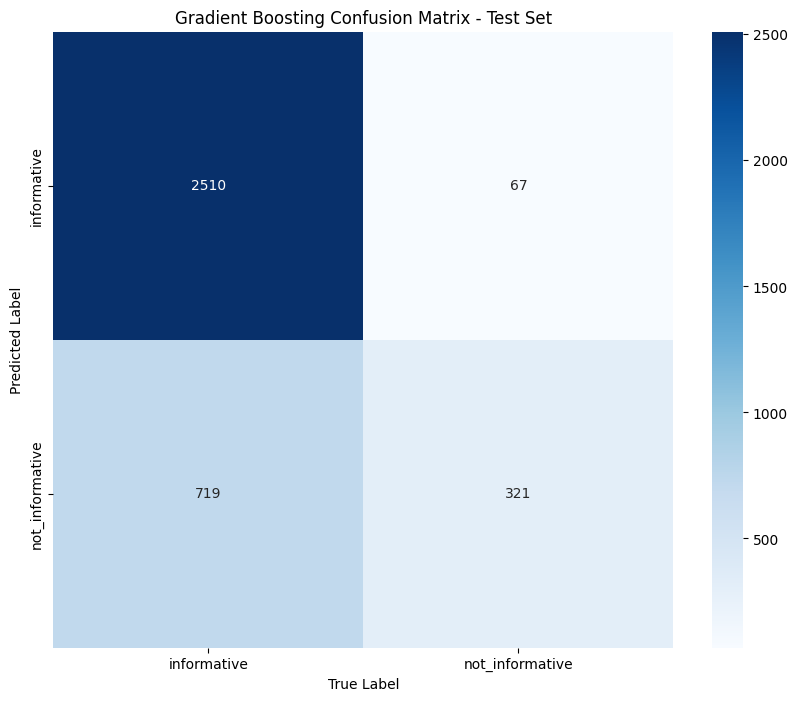

In [85]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_gb_clf_matrix = confusion_matrix(y_test, y_test_pred_gb, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_gb_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Gradient Boosting Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- High Recall for Informative Tweets (Class 1): The recall (97%) indicates that the model correctly identifies a significant portion of the actual informative tweets, but there are still some that it misses (higher false negatives).

- Moderate Precision for Informative Tweets (Class 1): The precision (78%) indicates that the model is quite likely to be correct when it predicts a tweet as informative, but there are still some false positives.

- False Positive Rate: The number of false positives (67) is relatively low, suggesting the model rarely misclassifies not_informative tweets as informative.

- False Negative Rate: The false negatives (719) are relatively higher, indicating that the model often misses informative tweets and incorrectly predicts them as not_informative.

- Overall Accuracy: With an accuracy of approximately 78%, the model performs well but has room for improvement, especially in improving the recall of not informative tweets.

##### XGBoost

In [86]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [87]:
# Evaluate on the validation set
y_val_pred = xgb_clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.77      0.49      0.60      1075
           1       0.81      0.94      0.87      2541

    accuracy                           0.80      3616
   macro avg       0.79      0.71      0.73      3616
weighted avg       0.80      0.80      0.79      3616



In [88]:
# Evaluate on the test set
y_test_pred_xgb = xgb_clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_xgb))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.77      0.50      0.61      1040
           1       0.82      0.94      0.88      2577

    accuracy                           0.81      3617
   macro avg       0.80      0.72      0.74      3617
weighted avg       0.81      0.81      0.80      3617



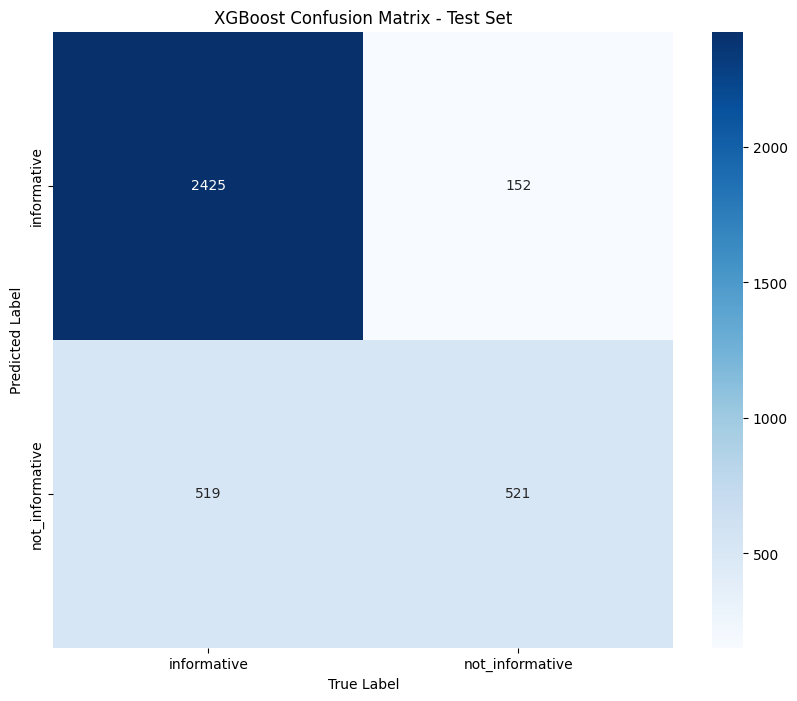

In [89]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_xgb_clf_matrix = confusion_matrix(y_test, y_test_pred_xgb, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_xgb_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('XGBoost Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- Moderate Recall for Not Informative Tweets (Class 0): The recall (50%) indicates that the model correctly identifies half of the actual not informative tweets, but there is room for improvement.

- High Precision and Recall for Informative Tweets (Class 1): The precision (82%) and recall (94%) for informative tweets indicate that the model is very effective in identifying informative tweets.

- False Positive Rate: The number of false positives (152) is relatively low, suggesting the model rarely misclassifies not informative tweets as informative.

- False Negative Rate: The false negatives (519) are relatively higher, indicating that the model often misses informative tweets and incorrectly predicts them as not informative.

- Overall Accuracy: With an accuracy of approximately 81%, the model performs well but has room for improvement, especially in improving the recall of not informative tweets.

##### CatBoost

In [90]:
# Initialize and train the CatBoost classifier
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train_tfidf, y_train)

In [91]:
# Evaluate on the validation set
y_val_pred = cat_clf.predict(X_val_tfidf)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1075
           1       0.80      0.94      0.87      2541

    accuracy                           0.80      3616
   macro avg       0.79      0.70      0.72      3616
weighted avg       0.79      0.80      0.78      3616



In [92]:
# Evaluate on the test set
y_test_pred_cat = cat_clf.predict(X_test_tfidf)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred_cat))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.80      0.46      0.59      1040
           1       0.82      0.95      0.88      2577

    accuracy                           0.81      3617
   macro avg       0.81      0.71      0.73      3617
weighted avg       0.81      0.81      0.80      3617



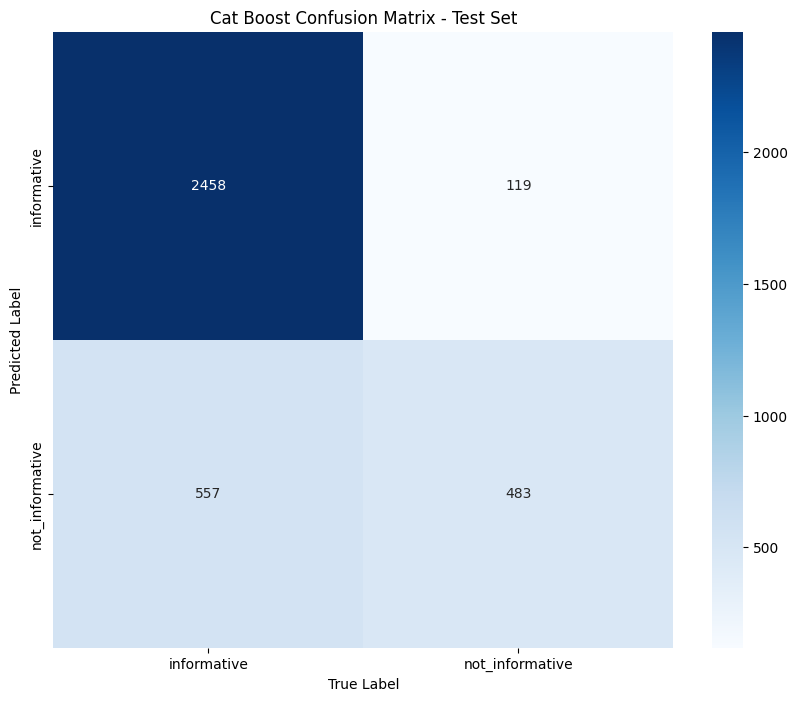

In [93]:
# Ensure the order of the labels is ['informative', 'not_informative']
labels_order = [1, 0]

# Compute the confusion matrix with the specified labels order
conf_cat_clf_matrix = confusion_matrix(y_test, y_test_pred_cat, labels=labels_order)

# Define the class labels for the plot
class_labels = ['informative', 'not_informative']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_cat_clf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Cat Boost Confusion Matrix - Test Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()

**Insights**

- Moderate Recall for Not Informative Tweets (Class 0): The recall (46%) indicates that the model correctly identifies less than half of the actual not informative tweets, but there is room for improvement.

- High Precision and Recall for Informative Tweets (Class 1): The precision (82%) and recall (95%) for informative tweets indicate that the model is very effective in identifying informative tweets.

- False Positive Rate: The number of false positives (119) is relatively low, suggesting the model rarely misclassifies not informative tweets as informative.

- False Negative Rate: The false negatives (557) are relatively higher, indicating that the model often misses informative tweets and incorrectly predicts them as not informative.

- Overall Accuracy: With an accuracy of approximately 81%, the model performs well but has room for improvement, especially in improving the recall of not informative tweets.

##### Model Comparison

In [94]:
# Dictionary to store metrics for each model
metrics_dict = {
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'Naive Bayes'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Logistic Regression metrics
acc_clf, prec_clf, rec_clf, f1_clf = calculate_metrics(y_test, y_test_pred_clf)
metrics_dict['Accuracy'].append(acc_clf)
metrics_dict['Precision'].append(prec_clf)
metrics_dict['Recall'].append(rec_clf)
metrics_dict['F1-Score'].append(f1_clf)

# Random Forest metrics
acc_rf, prec_rf, rec_rf, f1_rf = calculate_metrics(y_test, y_test_pred_rf)
metrics_dict['Accuracy'].append(acc_rf)
metrics_dict['Precision'].append(prec_rf)
metrics_dict['Recall'].append(rec_rf)
metrics_dict['F1-Score'].append(f1_rf)

# Gradient Boosting metrics
acc_gb, prec_gb, rec_gb, f1_gb = calculate_metrics(y_test, y_test_pred_gb)
metrics_dict['Accuracy'].append(acc_gb)
metrics_dict['Precision'].append(prec_gb)
metrics_dict['Recall'].append(rec_gb)
metrics_dict['F1-Score'].append(f1_gb)

# XGBoost metrics
acc_xgb, prec_xgb, rec_xgb, f1_xgb = calculate_metrics(y_test, y_test_pred_xgb)
metrics_dict['Accuracy'].append(acc_xgb)
metrics_dict['Precision'].append(prec_xgb)
metrics_dict['Recall'].append(rec_xgb)
metrics_dict['F1-Score'].append(f1_xgb)

# CatBoost metrics
acc_cat, prec_cat, rec_cat, f1_cat = calculate_metrics(y_test, y_test_pred_cat)
metrics_dict['Accuracy'].append(acc_cat)
metrics_dict['Precision'].append(prec_cat)
metrics_dict['Recall'].append(rec_cat)
metrics_dict['F1-Score'].append(f1_cat)

# Naive Bayes metrics
acc_nb, prec_nb, rec_nb, f1_nb = calculate_metrics(y_test, y_test_pred_nb)
metrics_dict['Accuracy'].append(acc_nb)
metrics_dict['Precision'].append(prec_nb)
metrics_dict['Recall'].append(rec_nb)
metrics_dict['F1-Score'].append(f1_nb)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# # Display the DataFrame
# print(metrics_df)

# print("")

# # Display the DataFrame as a table with lines
# print(metrics_df.to_string(index=False))

# print("")


# Display the DataFrame as a table with lines using tabulate
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))

+----+---------------------+------------+-------------+----------+------------+
|    | Model               |   Accuracy |   Precision |   Recall |   F1-Score |
+====+=====================+============+=============+==========+============+
|  0 | Logistic Regression |   0.812552 |    0.808976 | 0.812552 |   0.796556 |
+----+---------------------+------------+-------------+----------+------------+
|  1 | Random Forest       |   0.836052 |    0.832231 | 0.836052 |   0.827099 |
+----+---------------------+------------+-------------+----------+------------+
|  2 | Gradient Boosting   |   0.782693 |    0.791704 | 0.782693 |   0.745285 |
+----+---------------------+------------+-------------+----------+------------+
|  3 | XGBoost             |   0.814487 |    0.809458 | 0.814487 |   0.80078  |
+----+---------------------+------------+-------------+----------+------------+
|  4 | CatBoost            |   0.813105 |    0.811539 | 0.813105 |   0.795497 |
+----+---------------------+------------

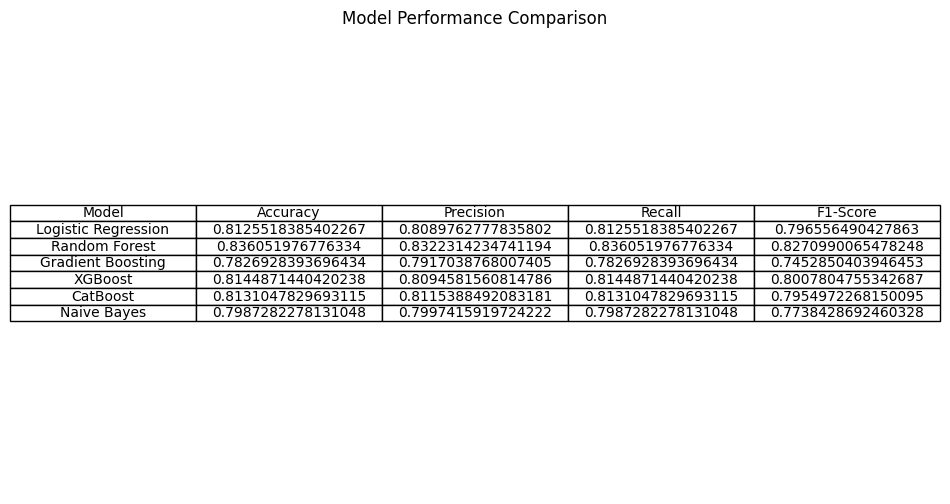

In [95]:
# Optionally, display the DataFrame as a table using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

plt.title('Model Performance Comparison')
plt.show()

### Model Optimizer

In [122]:
# Define the parameter grids for each model
param_grid_lr = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [100, 200, 300]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200, 300]
    }
]

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10]
}

In [126]:
# Function to perform grid search
def perform_grid_search(model, param_grid, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_scores = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, average='weighted'),
        'recall': recall_score(y_val, y_val_pred, average='weighted'),
        'f1_score': f1_score(y_val, y_val_pred, average='weighted')
    }
    return best_model, val_scores, grid_search.best_params_, grid_search.best_score_

In [127]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_scores = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train, average='weighted'),
        'recall': recall_score(y_train, y_pred_train, average='weighted'),
        'f1_score': f1_score(y_train, y_pred_train, average='weighted')
    }
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='weighted'),
        'recall': recall_score(y_test, y_pred_test, average='weighted'),
        'f1_score': f1_score(y_test, y_pred_test, average='weighted')
    }
    return train_scores, test_scores

In [128]:
# Models and their parameter grids
models = [
    (RandomForestClassifier(random_state=42), param_grid_rf, 'Random Forest'),
    (GradientBoostingClassifier(random_state=42), param_grid_gb, 'Gradient Boosting'),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, 'XGBoost'),
    (CatBoostClassifier(silent=True, random_state=42), param_grid_cat, 'CatBoost'),
    (MultinomialNB(), param_grid_nb, 'Naive Bayes'),
    (LogisticRegression(random_state=42), param_grid_lr, 'Logistic Regression')
]

In [129]:
# Perform grid search and evaluate optimized models
optimized_model_scores = {}
for model, param_grid, model_name in models:
    best_model, val_scores, best_params, best_score = perform_grid_search(model, param_grid, X_train_tfidf, y_train, X_val_tfidf, y_val)
    optimized_train_scores, optimized_test_scores = evaluate_model(best_model, X_train_tfidf, X_test_tfidf, y_train, y_test)
    optimized_model_scores[model_name] = {
        'val_scores': val_scores, 
        'optimized_train_scores': optimized_train_scores, 
        'optimized_test_scores': optimized_test_scores, 
        'best_params': best_params, 
        'best_score': best_score
    }

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\disaster-tweets\dis\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\disaster-tweets\dis\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [130]:
# Print results
for model_name, scores in optimized_model_scores.items():
    print(f"\n{model_name} Best Parameters: {scores['best_params']}")
    print(f"{model_name} Best Grid Search Score: {scores['best_score']:.4f}")
    print(f"{model_name} Validation Scores: {scores['val_scores']}")
    print(f"{model_name} Optimized Train Scores: {scores['optimized_train_scores']}")
    print(f"{model_name} Optimized Test Scores: {scores['optimized_test_scores']}")


Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Best Grid Search Score: 0.8123
Random Forest Validation Scores: {'accuracy': 0.8207964601769911, 'precision': 0.8158778990201151, 'recall': 0.8207964601769911, 'f1_score': 0.8115031731576137}
Random Forest Optimized Train Scores: {'accuracy': 0.9832242603004885, 'precision': 0.9832506267325027, 'recall': 0.9832242603004885, 'f1_score': 0.9831462833562072}
Random Forest Optimized Test Scores: {'accuracy': 0.8352225601327067, 'precision': 0.8315497175745515, 'recall': 0.8352225601327067, 'f1_score': 0.8258686535976757}

Gradient Boosting Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Gradient Boosting Best Grid Search Score: 0.7972
Gradient Boosting Validation Scores: {'accuracy': 0.7995022123893806, 'precision': 0.7922360212661922, 'recall': 0.7995022123893806, 'f1_score': 0.7870

In [131]:
# Select the best model based on the smallest difference between train and test F1-scores
best_model_name = None
smallest_diff = float('inf')
for model_name, scores in optimized_model_scores.items():
    train_f1 = scores['optimized_train_scores']['f1_score']
    test_f1 = scores['optimized_test_scores']['f1_score']
    diff = abs(train_f1 - test_f1)
    if diff < smallest_diff:
        smallest_diff = diff
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with F1-score difference of {smallest_diff:.4f}")


Best Model: Naive Bayes with F1-score difference of 0.0134


In [96]:
# Define the parameter grids for each model

# Logistic Regression
param_grid_lr = [
    {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear', 'saga']
    }
]

# Random Forest
param_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting
param_grid_gb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 4, 5],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# XGBoost
param_grid_xgb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 4, 5],
    'clf__subsample': [0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.8, 0.9, 1.0]
}

# CatBoost
param_grid_cat = {
    'clf__iterations': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__depth': [3, 4, 5]
}

# Naive Bayes
param_grid_nb = {
    'clf__alpha': [0.01, 0.1, 1, 10]
}



In [97]:
# Initialize the models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(silent=True, random_state=42)
nb = MultinomialNB()

In [98]:
# Create pipelines for each model
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', GradientBoostingClassifier(random_state=42))
])

pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

pipeline_cat = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', CatBoostClassifier(silent=True, random_state=42))
])

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', MultinomialNB())
])

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')),
    ('clf', LogisticRegression(random_state=42))
])

In [99]:
# Perform grid search for each model
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

##### Logistic Regression

In [100]:
best_params_lr, best_score_lr = perform_grid_search(pipeline_lr, param_grid_lr, X_train, y_train)
print(f"Logistic Regression best parameters: {best_params_lr}")
print(f"Logistic Regression best score: {best_score_lr}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Logistic Regression best parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Logistic Regression best score: 0.808093262201146


In [ ]:
best_params_lr, best_score_lr = perform_grid_search(pipeline_lr, param_grid_lr, X_train, y_train)
print(f"Logistic Regression best parameters: {best_params_lr}")
print(f"Logistic Regression best score: {best_score_lr}")

##### Naive Bayes

In [101]:
best_params_nb, best_score_nb = perform_grid_search(pipeline_nb, param_grid_nb, X_train, y_train)
print(f"Naive Bayes best parameters: {best_params_nb}")
print(f"Naive Bayes best score: {best_score_nb}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Naive Bayes best parameters: {'clf__alpha': 0.01}
Naive Bayes best score: 0.7908557321112535


##### Random Forest

In [102]:
# Random Forest
best_params_rf, best_score_rf = perform_grid_search(pipeline_rf, param_grid_rf, X_train, y_train)
print(f"Random Forest best parameters: {best_params_rf}")
print(f"Random Forest best score: {best_score_rf}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Random Forest best score: 0.822472544632898


##### Gradient Boosting

In [103]:
best_params_gb, best_score_gb = perform_grid_search(pipeline_gb, param_grid_gb, X_train, y_train)
print(f"Gradient Boosting best parameters: {best_params_gb}")
print(f"Gradient Boosting best score: {best_score_gb}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Gradient Boosting best parameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Gradient Boosting best score: 0.8090144112791684


##### XGBoost

In [104]:
best_params_xgb, best_score_xgb = perform_grid_search(pipeline_xgb, param_grid_xgb, X_train, y_train)
print(f"XGBoost best parameters: {best_params_xgb}")
print(f"XGBoost best score: {best_score_xgb}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
XGBoost best score: 0.8154676388915446


##### CatBoost

In [106]:
best_params_cat, best_score_cat = perform_grid_search(pipeline_cat, param_grid_cat, X_train, y_train)
print(f"CatBoost best parameters: {best_params_cat}")
print(f" Train CatBoost best score: {best_score_cat}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CatBoost best parameters: {'clf__depth': 4, 'clf__iterations': 300, 'clf__learning_rate': 0.2}
CatBoost best score: 0.8083692924811918


#### Cross Validate

In [115]:
# Function to perform grid search
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [116]:
# Function to perform cross-validation and print scores
def perform_cross_validation(model, X_train, y_train, model_name):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_weighted': make_scorer(f1_score, average='weighted')
    }
    cross_val_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print(f"\n{model_name} Cross-Validation Results:")
    print("Train Scores:")
    print(f"Accuracy: {cross_val_results['train_accuracy'].mean():.4f}")
    print(f"Precision: {cross_val_results['train_precision'].mean():.4f}")
    print(f"Recall: {cross_val_results['train_recall'].mean():.4f}")
    print(f"F1-Score: {cross_val_results['train_f1_weighted'].mean():.4f}")
    print("Test Scores:")
    print(f"Accuracy: {cross_val_results['test_accuracy'].mean():.4f}")
    print(f"Precision: {cross_val_results['test_precision'].mean():.4f}")
    print(f"Recall: {cross_val_results['test_recall'].mean():.4f}")
    print(f"F1-Score: {cross_val_results['test_f1_weighted'].mean():.4f}")

In [117]:
# List of models and their names
models = [
    (pipeline_rf, param_grid_rf, 'Random Forest'),
    (pipeline_gb, param_grid_gb, 'Gradient Boosting'),
    (pipeline_xgb, param_grid_xgb, 'XGBoost'),
    (pipeline_cat, param_grid_cat, 'CatBoost'),
    (pipeline_nb, param_grid_nb, 'Naive Bayes'),
    (pipeline_lr, param_grid_lr, 'Logistic Regression')
]

# Perform grid search and cross-validation for each model
for pipeline, param_grid, model_name in models:
    best_model = perform_grid_search(pipeline, param_grid, X_train, y_train)
    perform_cross_validation(best_model, X_train, y_train, model_name)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest Cross-Validation Results:
Train Scores:
Accuracy: 0.9846
Precision: 0.9846
Recall: 0.9846
F1-Score: 0.9846
Test Scores:
Accuracy: 0.8225
Precision: 0.8163
Recall: 0.8225
F1-Score: 0.8140
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Gradient Boosting Cross-Validation Results:
Train Scores:
Accuracy: 0.9267
Precision: 0.9301
Recall: 0.9267
F1-Score: 0.9240
Test Scores:
Accuracy: 0.8090
Precision: 0.8020
Recall: 0.8090
F1-Score: 0.7962
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

XGBoost Cross-Validation Results:
Train Scores:
Accuracy: 0.8837
Precision: 0.8825
Recall: 0.8837
F1-Score: 0.8798
Test Scores:
Accuracy: 0.8155
Precision: 0.8086
Recall: 0.8155
F1-Score: 0.8081
Fitting 5 folds for each of 27 candidates, totalling 135 fits

CatBoost Cross-Validation Results:
Train Scores:
Accuracy: 0.8716
Precision: 0.8762
Recall: 0.8716
F1-Score: 0.8630
Test Scores:
Accuracy: 0.8